# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

sum_sq    df         F    PR(>F)  p_val_adj
A1BG   0.122578  12.0  2.796490  0.003701   0.010364
AAAS   0.017527  12.0  0.944161  0.509517   0.596369
AACS   0.136394  12.0  2.729393  0.004508   0.012212
AADAT  0.057031  12.0  5.478881  0.000002   0.000016
AAGAB  0.043359  12.0  2.127609  0.026045   0.053640

In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [7]:
pb_dir_path = 'results/'

In [8]:
os.listdir(pb_dir_path)

['.ipynb_checkpoints',
 'ancova_3df_res.pkl',
 'ancova_perm_res.pkl',
 'ancova_res.pkl',
 'chimp_clusters_28.csv',
 'chimp_clusters_50.csv',
 'chimp_clusters_77.csv',
 'gene_selection_df.csv',
 'hs_anova_inter_clusters.csv',
 'hs_layers.csv',
 'hs_prof.csv',
 'hs_prof_anova.csv',
 'hs_ttest_inter_clusters.csv',
 'human_clusters_28.csv',
 'human_clusters_50.csv',
 'human_clusters_67.csv',
 'human_clusters_77.csv',
 'human_clusters_ancova.csv',
 'hum_spec_onehot.csv',
 'l1_distances.pkl',
 'macaque_clusters_28.csv',
 'macaque_clusters_77.csv',
 'mean_norm_clust_allgenes.csv',
 'optimal_model_res.pkl',
 'pb_mammals_samplenorm_mean_filtered.h5ad',
 'specie_specific_genes_tr28.pkl',
 'specie_specific_genes_tr35.pkl',
 'specie_specific_genes_tr50.pkl',
 'specie_specific_genes_tr67.pkl',
 'specie_specific_genes_tr77.pkl',
 'zscore_norm_clust_allgenes.csv']

In [9]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean_filtered.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 5390
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [10]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

5390

## Specie-specific genes

In [11]:
model_res = pd.read_csv('results/gene_selection_df.csv', index_col=0)
model_res.head()

human     chimp   macaque
AACS   0.001206  0.014287  0.318736
AAGAB  0.731575  0.661344  0.024143
AAK1   0.000658  0.699175  0.069657
AAMP   0.762617  0.530339  0.947528
AAR2   0.312623  0.436571  0.343371

In [12]:
import pickle
with open("results/ancova_perm_res.pkl", "rb") as file:
    ancova_results = pickle.load(file)

In [13]:
# import pickle
# with open("./results/specie_specific_genes_tr50.pkl", "rb") as file:
#     genes_dict77 = pickle.load(file)

In [14]:
sign_genes = {key:value[value['p-value'] < 0.05].index for key, value in ancova_results.items()}
sign_genes

{'human-chimp': Index(['ABCG4', 'ABHD6', 'ABI2', 'ABLIM3', 'ACHE', 'ACSL1', 'ACTG1', 'ACTN2',
        'ADAM15', 'ADGRB2',
        ...
        'ZEB2', 'ZFPL1', 'ZMYND8', 'ZNF32', 'ZNF362', 'ZNF608', 'ZNF689',
        'ZNF692', 'ZNF706', 'ZNF74'],
       dtype='object', length=786),
 'human-macaque': Index(['AACS', 'AAGAB', 'AAK1', 'AAR2', 'AARS1', 'AATK', 'ABAT', 'ABCC10',
        'ABCD4', 'ABHD10',
        ...
        'ZNF575', 'ZNF576', 'ZNF592', 'ZNF593', 'ZNF655', 'ZNF689', 'ZNF703',
        'ZNF706', 'ZNF768', 'ZNFX1'],
       dtype='object', length=2085),
 'chimp-macaque': Index(['AARS1', 'AATK', 'ABAT', 'ABCC10', 'ABCC8', 'ABCD4', 'ABHD10', 'ABLIM3',
        'ACAD9', 'ACADVL',
        ...
        'ZNF184', 'ZNF189', 'ZNF304', 'ZNF341', 'ZNF511', 'ZNF536', 'ZNF576',
        'ZNF655', 'ZNF689', 'ZNF703'],
       dtype='object', length=1562)}

Попробуем определить человеко-специфичные гены как $(HC\bigcap HM)\setminus CM$

In [15]:
hs_genes = sign_genes['human-chimp'].intersection(sign_genes['human-macaque']).difference(sign_genes['chimp-macaque'])
hs_genes, hs_genes.size

(Index(['ABHD6', 'ABI2', 'ADAM15', 'ADI1', 'ADORA1', 'AFTPH', 'AHNAK2', 'ALCAM',
        'AMFR', 'ANK2',
        ...
        'VIPAS39', 'VLDLR', 'WWP1', 'YWHAE', 'YWHAH', 'ZBTB18', 'ZBTB46',
        'ZEB2', 'ZNF362', 'ZNF706'],
       dtype='object', length=230),
 230)

## Helpful functions

In [16]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [17]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [18]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Clusterisation

In [486]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [487]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_hs = df[hs_genes].copy()

## Hierarchial

D:\Projects\spatialMPFC\venv\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


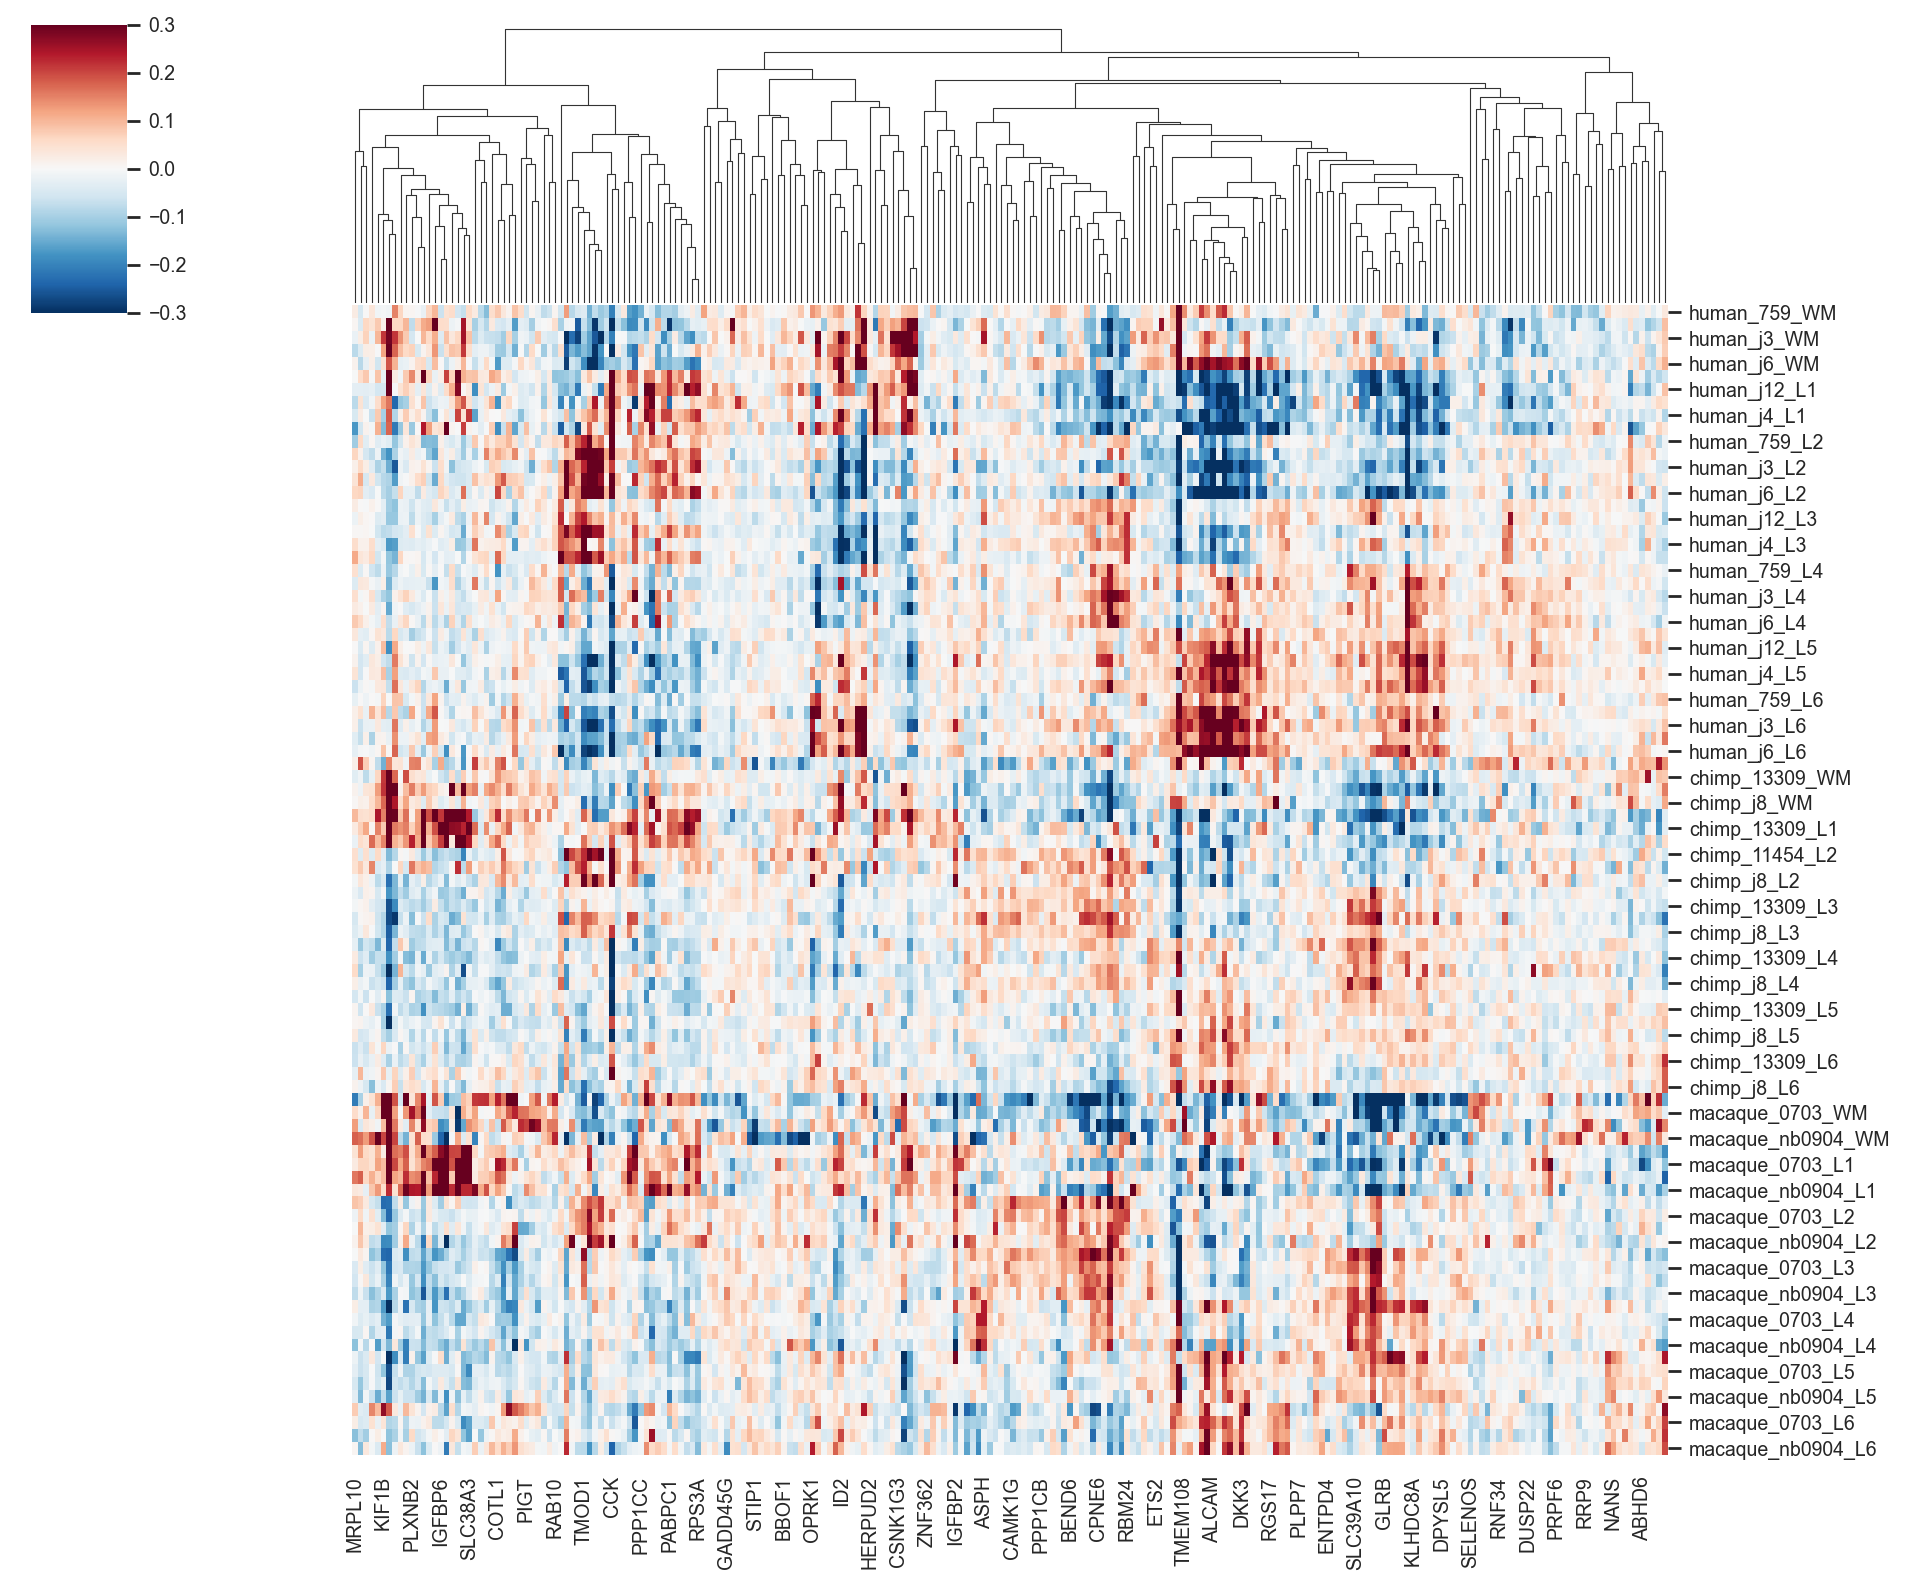

In [488]:
sns.set(font_scale=0.8)
sns.clustermap(df_hs, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.3, vmin=-0.3, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

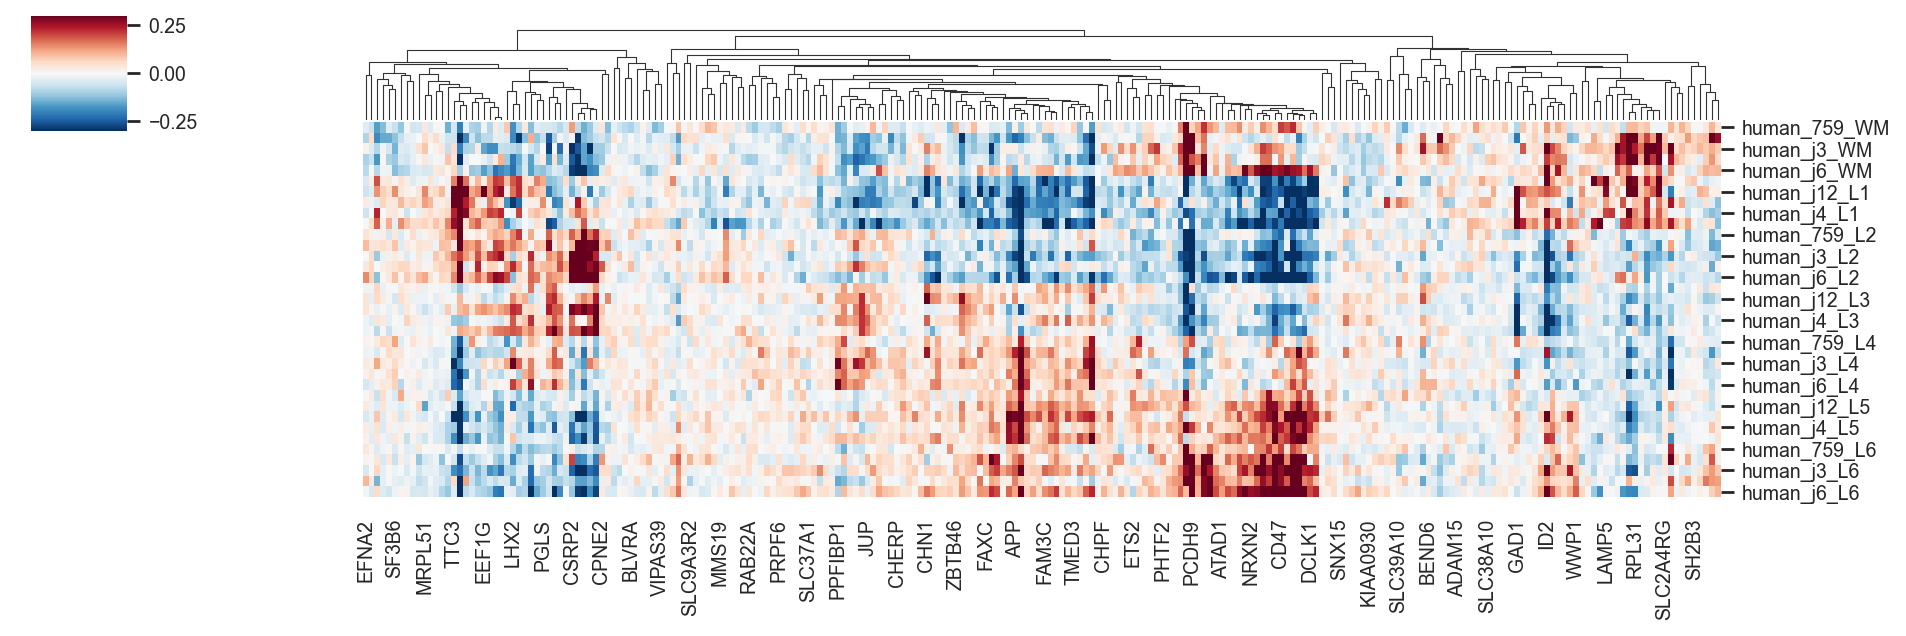

In [489]:
sns.clustermap(df_hs.loc[sample_order['human']], figsize=(12, 4), cmap="RdBu_r", center=0, vmax=0.3, vmin=-0.3, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Spectral clusterisation

In [490]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
#aff_matrix = pairwise_kernels(df_hs.T[sample_order['human']], metric='cosine') + 1
n_clusters = 7
clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=4)
#clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=4)
#clustering.fit(aff_matrix)
clustering.fit(df_hs.T[sample_order['human']])

SpectralClustering(affinity='nearest_neighbors', n_clusters=7, random_state=4)

In [491]:
labels = pd.Series(clustering.labels_, index=hs_genes).sort_values()
order = labels.sort_values().index

In [492]:
labels.to_csv('./results/human_clusters_ancova.csv')

In [493]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [494]:
colors = cluster_color[:n_clusters]
clusters = np.arange(n_clusters)

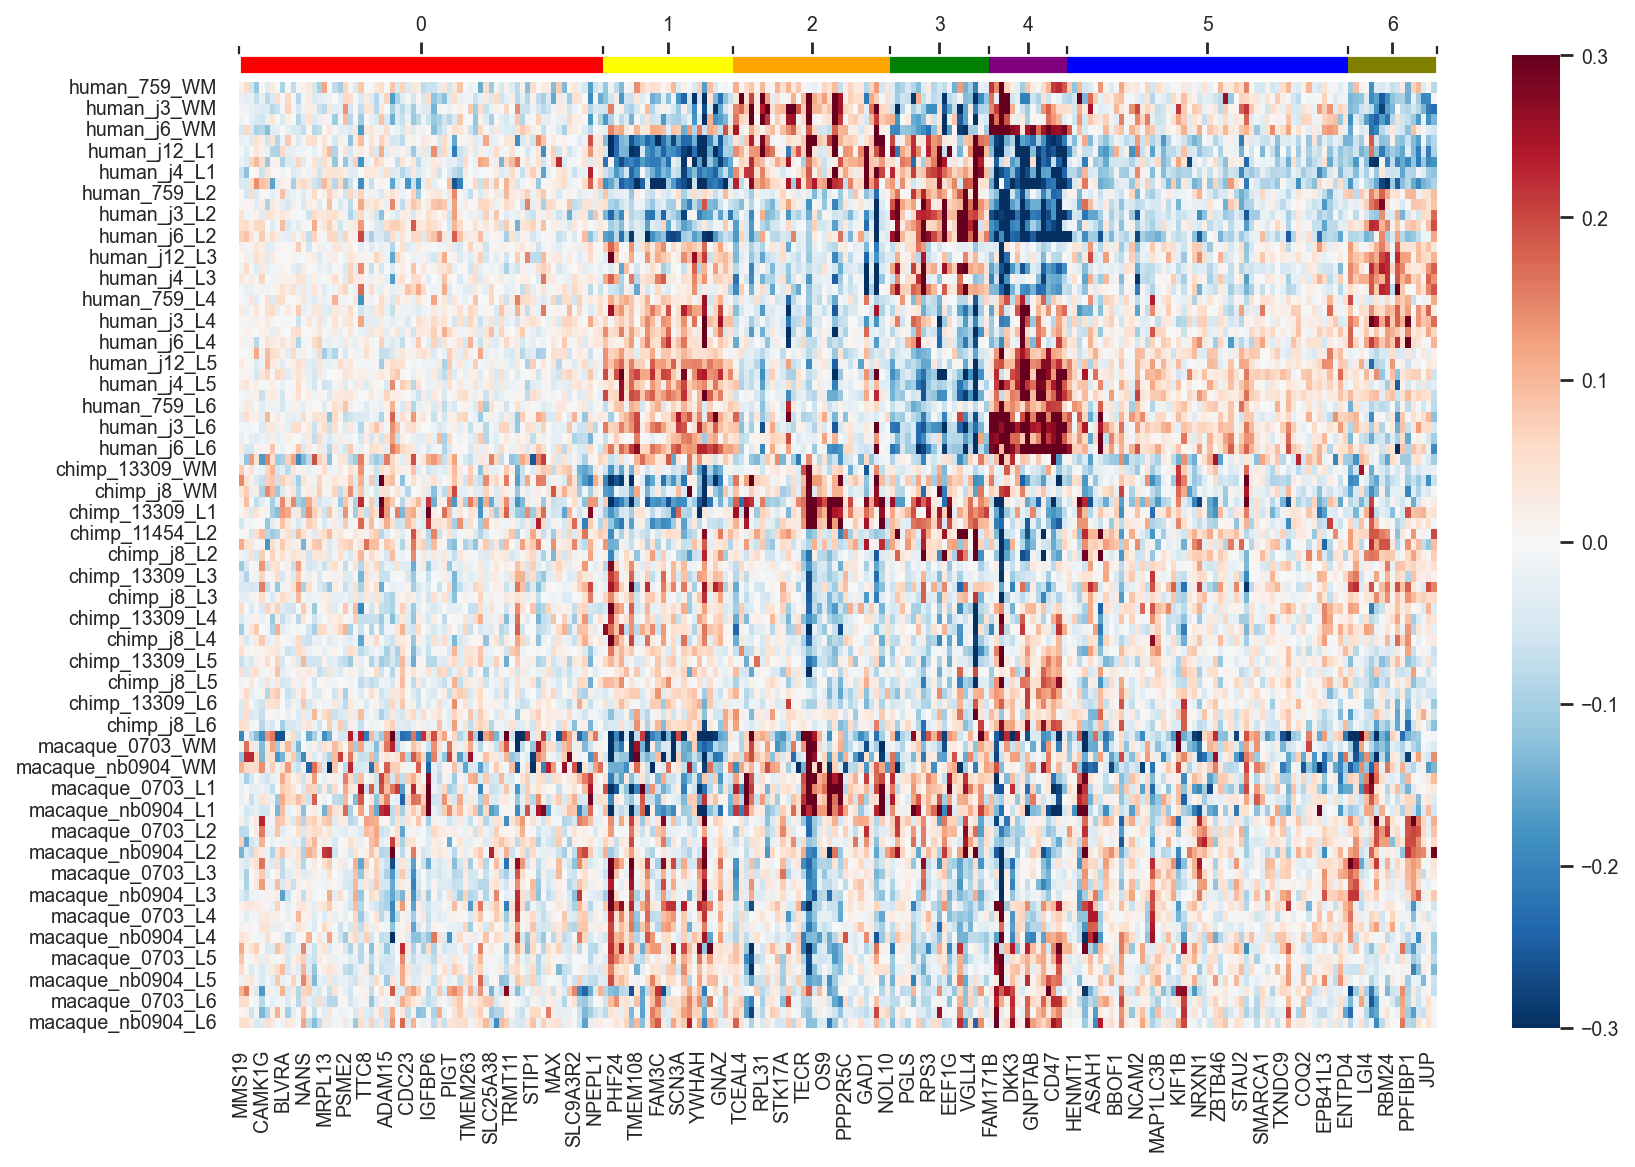

In [495]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_hs[order], ax=ax, cmap="RdBu_r", vmax=0.3, vmin=-0.3, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

In [496]:
labels[labels == 1].size

25

## Cluster profiles

In [497]:
df_annotation = df_hs.copy()
df_annotation['layer'] = adata_pb_norm.obs.layer
df_annotation['condition'] = adata_pb_norm.obs.condition

In [498]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

ABHD6      ABI2    ADAM15      ADI1    ADORA1     AFTPH  \
condition layer                                                               
chimp     L1    -0.128820 -0.059771  0.120247  0.232106 -0.142581 -0.002926   
          L2     0.081598  0.010944 -0.003475 -0.029761 -0.145785  0.063356   
          L3    -0.039633  0.062355 -0.044347 -0.081698 -0.120843  0.044030   
          L4     0.020756  0.020539 -0.039034 -0.069586  0.006139  0.001397   
          L5     0.006443 -0.015000 -0.052907 -0.055009  0.065859 -0.012946   

                   AHNAK2     ALCAM      AMFR      ANK2  ...   VIPAS39  \
condition layer                                          ...             
chimp     L1    -0.091653  0.009130  0.083703 -0.074303  ... -0.059544   
          L2    -0.052059 -0.242804  0.070298 -0.107423  ...  0.045883   
          L3    -0.010910 -0.066325 -0.016274 -0.046509  ... -0.000079   
          L4     0.062326  0.006249 -0.060398 -0.037624  ...  0.029193   
          L5     0.082473  0.134409 -0.049253 -0.015614  ... -0.027980   

                    VLDLR      WWP1     YWHAE     YWHAH    ZBTB18    ZBTB46  \
condition layer                                                               
chimp     L1    -0.015714 -0.021681 -0.043822 -0.213943 -0.154330  0.026107   
          L2     0.094521  0.075032  0.006897 -0.006026  0.229193  0.072883   
          L3     0.069694 -0.028285  0.031802  0.053368  0.178206  0.070541   
          L4    -0.048778 -0.005638  0.006790  0.066827  0.129230  0.024286   
          L5    -0.039212  0.002174  0.007214  0.060298  0.023022 -0.064324   

                     ZEB2    ZNF362    ZNF706  
condition layer                                
chimp     L1     0.037896  0.034277  0.020416  
          L2     0.051170 -0.024460  0.121583  
          L3    -0.040480  0.001123  0.067006  
          L4    -0.075607 -0.028787 -0.001815  
          L5    -0.057856  0.018199 -0.035676  

[5 rows x 230 columns]

In [499]:
# fig, axes = plt.subplots(2, 2,  figsize=(14, 3.5 * 2), gridspec_kw={'hspace': 0.4})
# for gene, ax in zip(layer_mean.columns, axes.flatten()):
#     (
#             layer_mean[gene]
#             .reorder_levels(['layer', 'condition'])
#             .unstack().loc[layers]
#             .plot
#             .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
#     )
#     ax.grid(False)

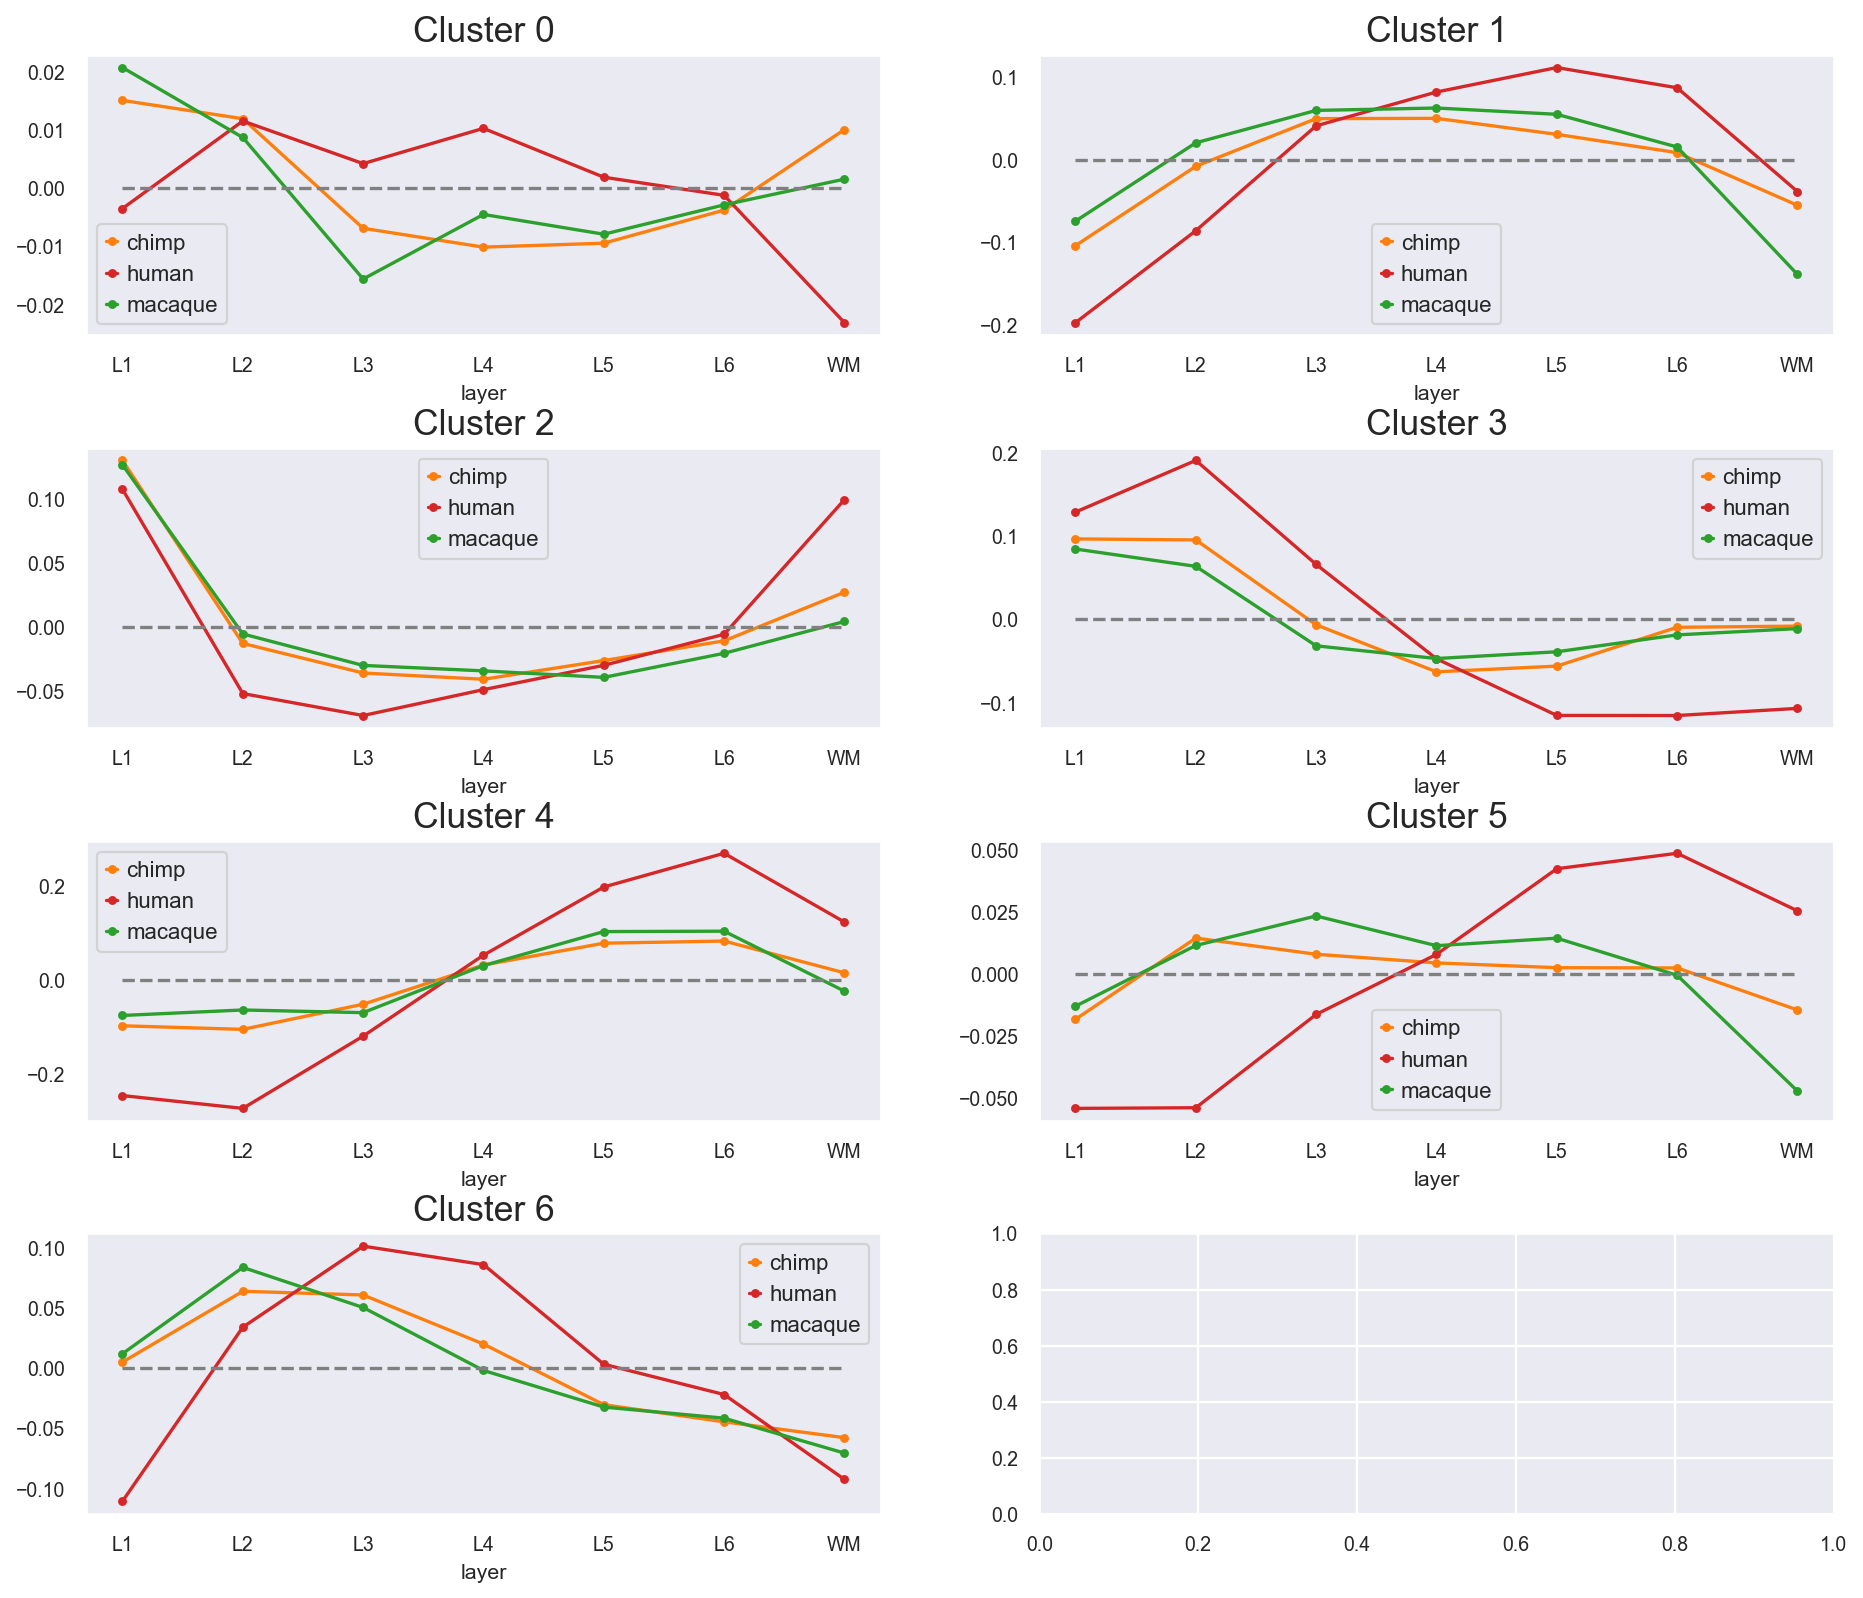

In [500]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

Text(0.5, 0.98, 'Median everaging for profiles')

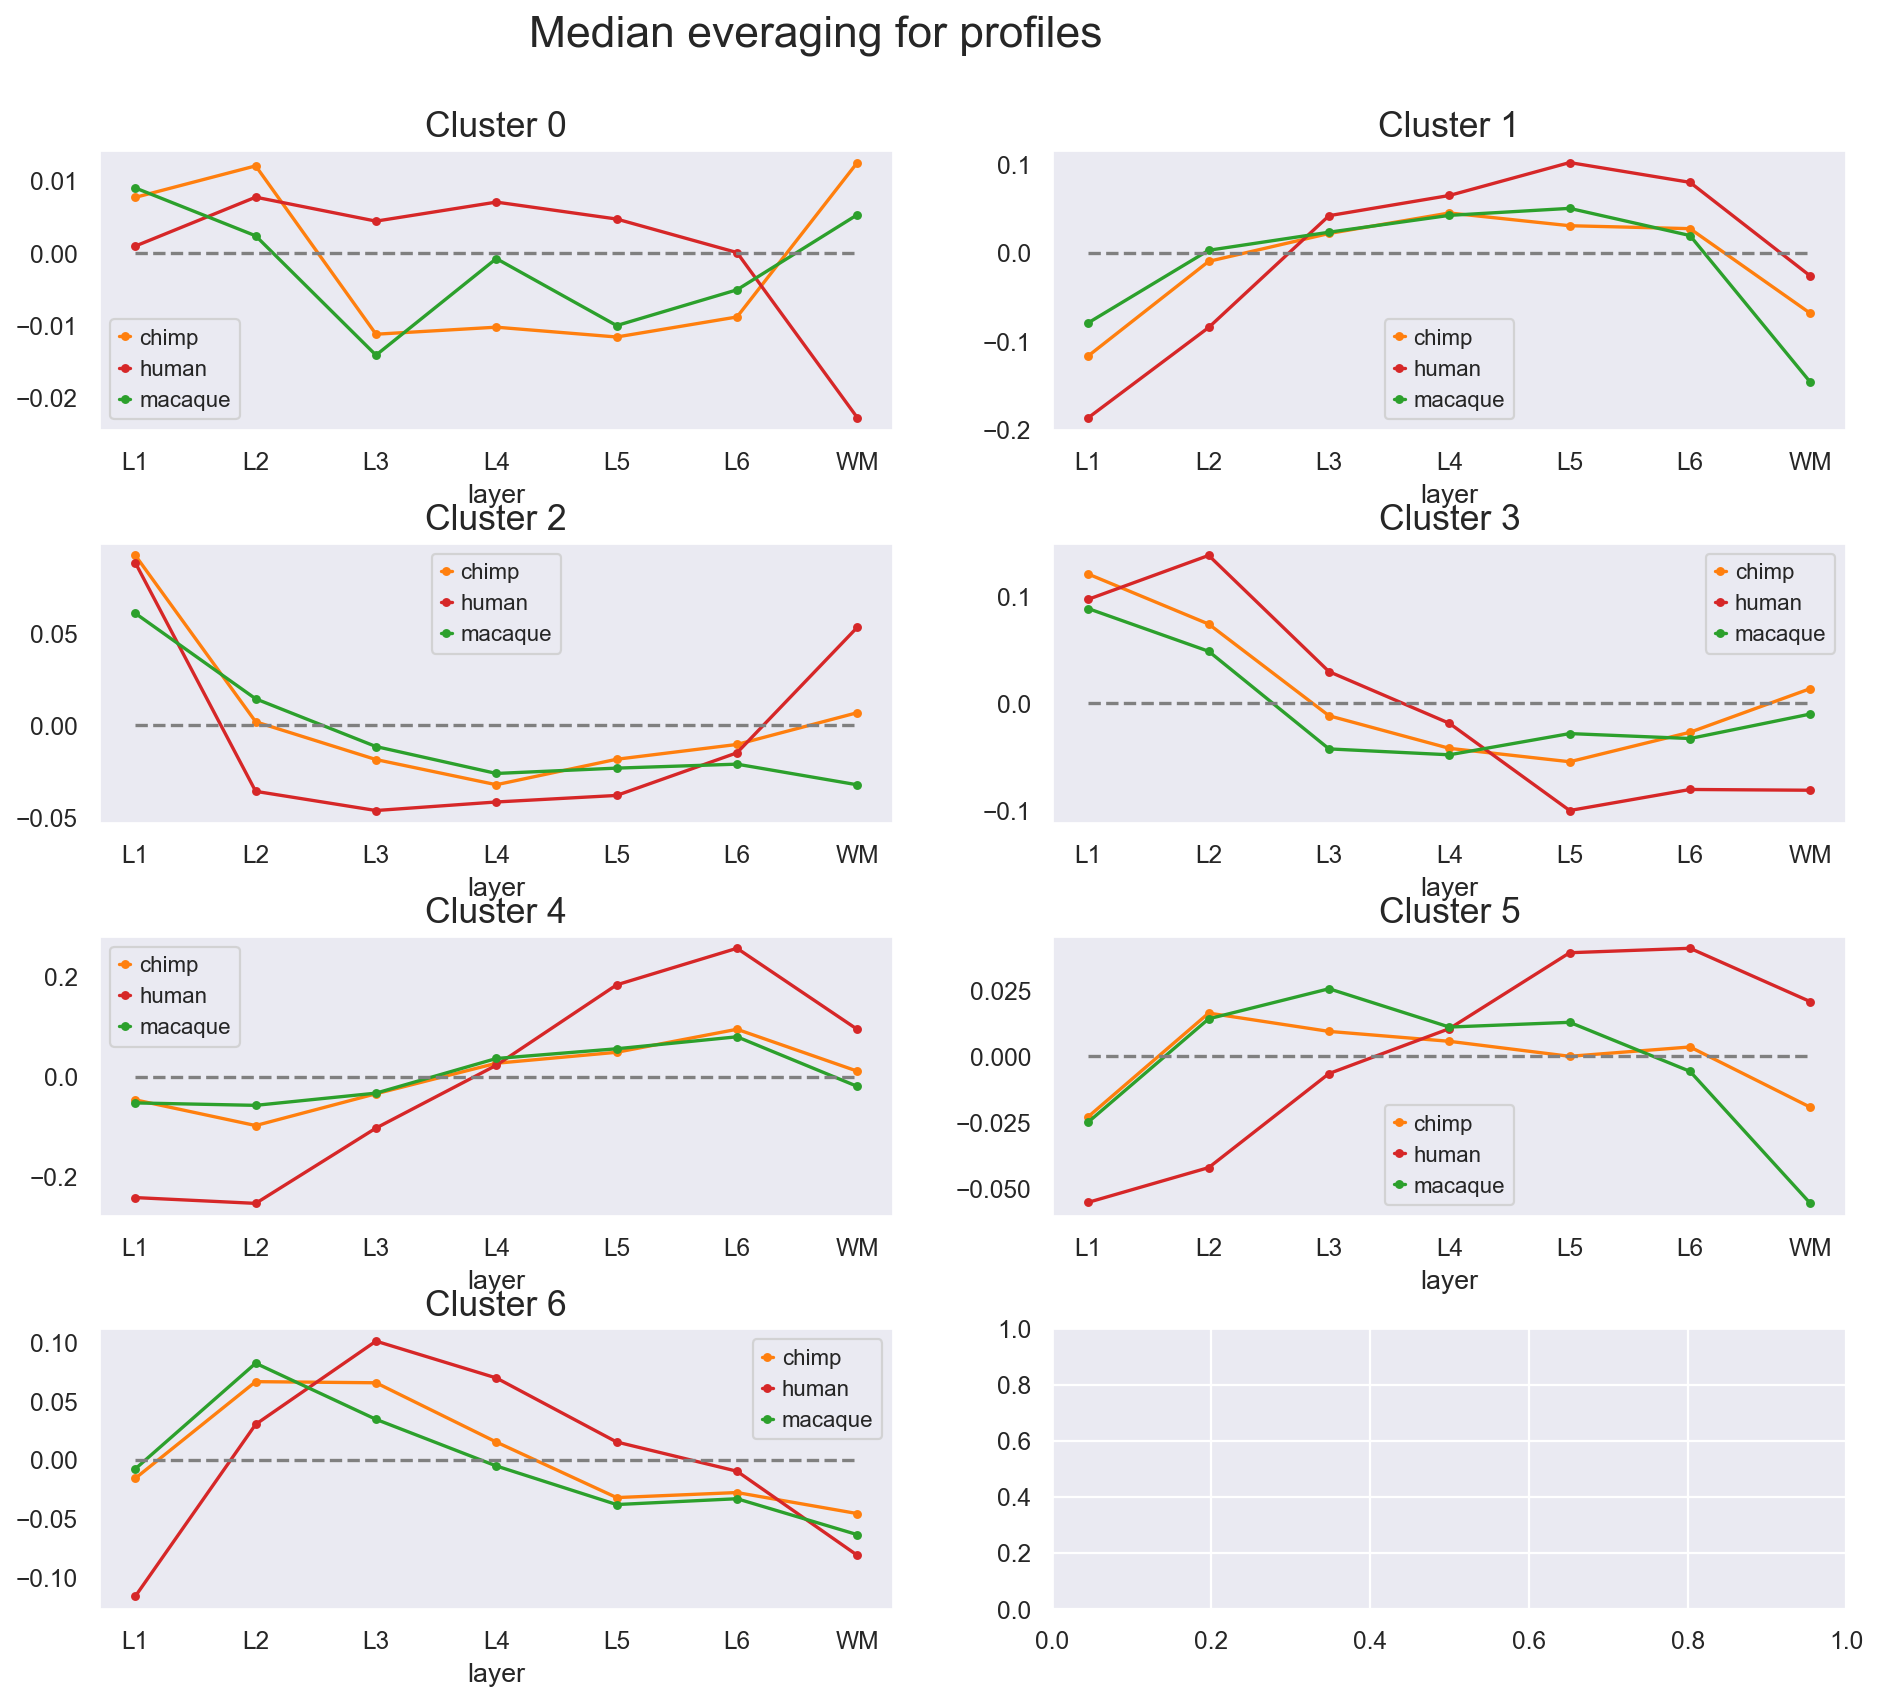

In [501]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .median(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Median averaging for profiles', fontsize=20)

# 4 Species

In [502]:
pb_dir_path = '../../data/pseudobulks/'
adata_pb_4spe = sc.read_h5ad(pb_dir_path + '4spe_pb_mean_filt_nor_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_4spe

AnnData object with n_obs × n_vars = 116 × 6523
    obs: 'layer', 'sample_id', 'condition', 'lib_size', 'log_lib_size'
    var: 'gene_name'
    uns: 'log1p'

In [503]:
df_4spe = pd.DataFrame(adata_pb_4spe.X, index=adata_pb_4spe.obs_names, columns=adata_pb_4spe.var_names)

In [504]:
hs_genes_inter = df_4spe.columns.intersection(hs_genes)
hs_genes_inter.size

154

In [505]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque', 'treeshrew']:
    samples = df_4spe.loc[df_4spe.index.str.contains(cond)].index
    order_s = sorted(samples.tolist(), key=lambda x: x[:2])
    order_laminar = list(filter(lambda x: 'L' in x, order_s))
    order_wm = list(filter(lambda x: 'WM' in x, order_s))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque'] + sample_order['treeshrew']
df_4spe = df_4spe.loc[sample_order['all']]
df_4spe_hs = df_4spe[hs_genes_inter]

In [506]:
order_4spe = order.intersection(hs_genes_inter)

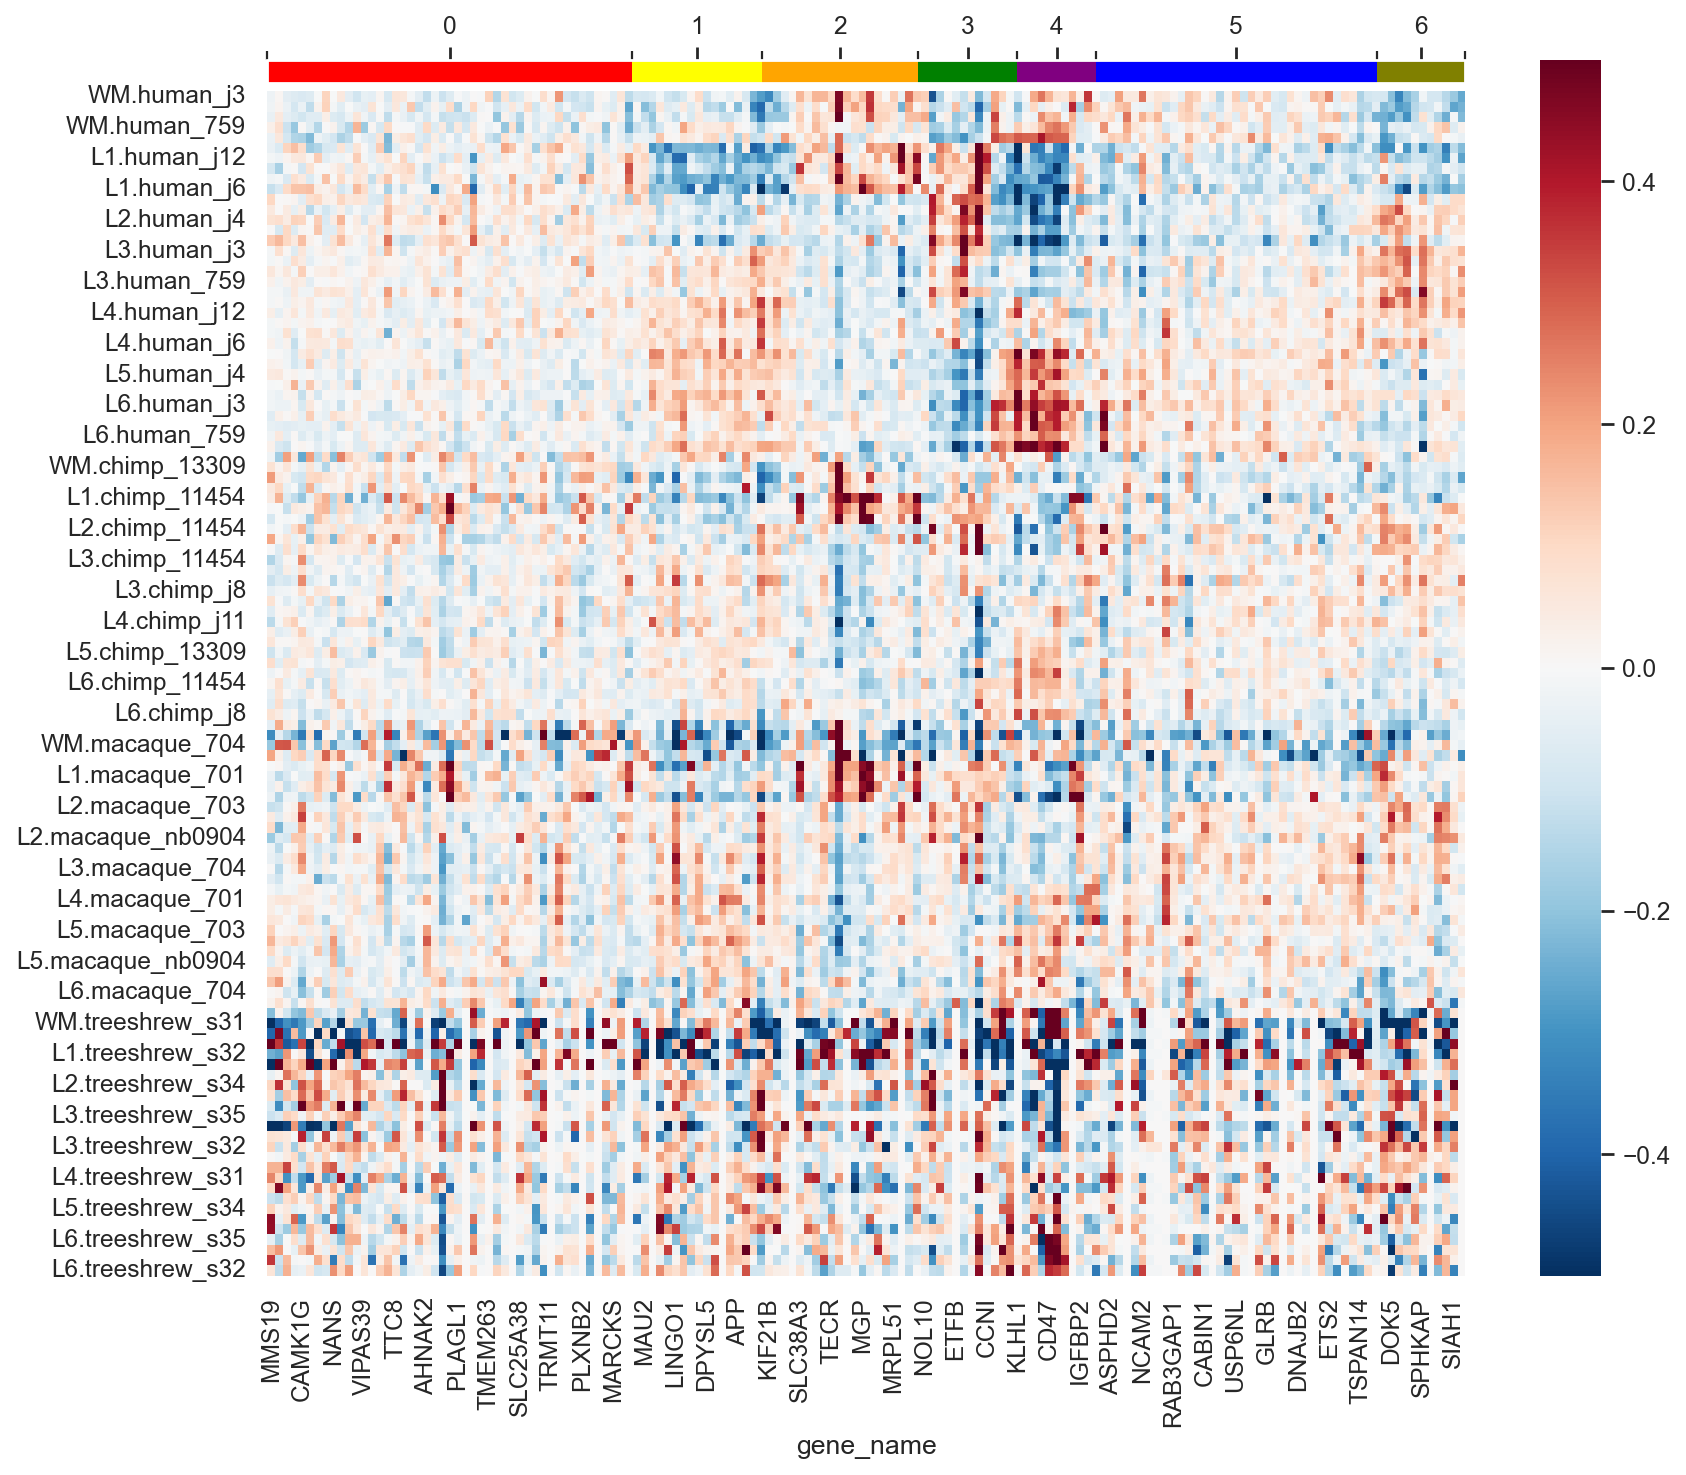

In [507]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_4spe_hs[order_4spe], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

## Cluster profiles (mean)

In [508]:
df_annotation = df_4spe_hs.copy()
df_annotation['layer'] = adata_pb_4spe.obs.layer
df_annotation['condition'] = adata_pb_4spe.obs.condition

In [509]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

gene_name          GPR153    FBLIM1    IGSF21    ZNF362    SLC2A1       HYI  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1     0.170319  0.080998 -0.231617  0.064203  0.549012  0.095937   
          L2     0.103709 -0.076954 -0.164320 -0.014871 -0.105929  0.035265   
          L3     0.135652  0.004237 -0.013440  0.000755 -0.085139 -0.019817   
          L4    -0.021479 -0.004656  0.176425 -0.038331 -0.159376 -0.102893   

gene_name          ADAM15    KIF21B    ADORA1   KLHDC8A  ...      GNAZ  \
condition layer                                          ...             
chimp     6a          NaN       NaN       NaN       NaN  ...       NaN   
          L1     0.142487 -0.061434 -0.160815 -0.203626  ... -0.039300   
          L2    -0.007318  0.055080 -0.223321 -0.038123  ...  0.123926   
          L3    -0.062504  0.114423 -0.185453  0.010068  ...  0.102861   
          L4    -0.046611  0.066458 -0.005093  0.023488  ...  0.079627   

gene_name          CABIN1    ASPHD2      TSPO  KIAA0930    PLXNB2     NCAM2  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1     0.007308 -0.039383  0.156637  0.000218  0.229904  0.075177   
          L2     0.034510  0.071358 -0.074830 -0.029361  0.058206  0.041594   
          L3     0.015382  0.092665 -0.067673 -0.041037 -0.121396 -0.014084   
          L4    -0.018344  0.007259 -0.098315 -0.017627 -0.165143 -0.011287   

gene_name            JAM2       APP      ETS2  
condition layer                                
chimp     6a          NaN       NaN       NaN  
          L1     0.285189 -0.117498  0.189577  
          L2    -0.111063 -0.100191 -0.086869  
          L3    -0.064058  0.082678 -0.065697  
          L4    -0.068254  0.083122  0.099880  

[5 rows x 154 columns]

Text(0.5, 0.98, 'Mean everaging for profiles')

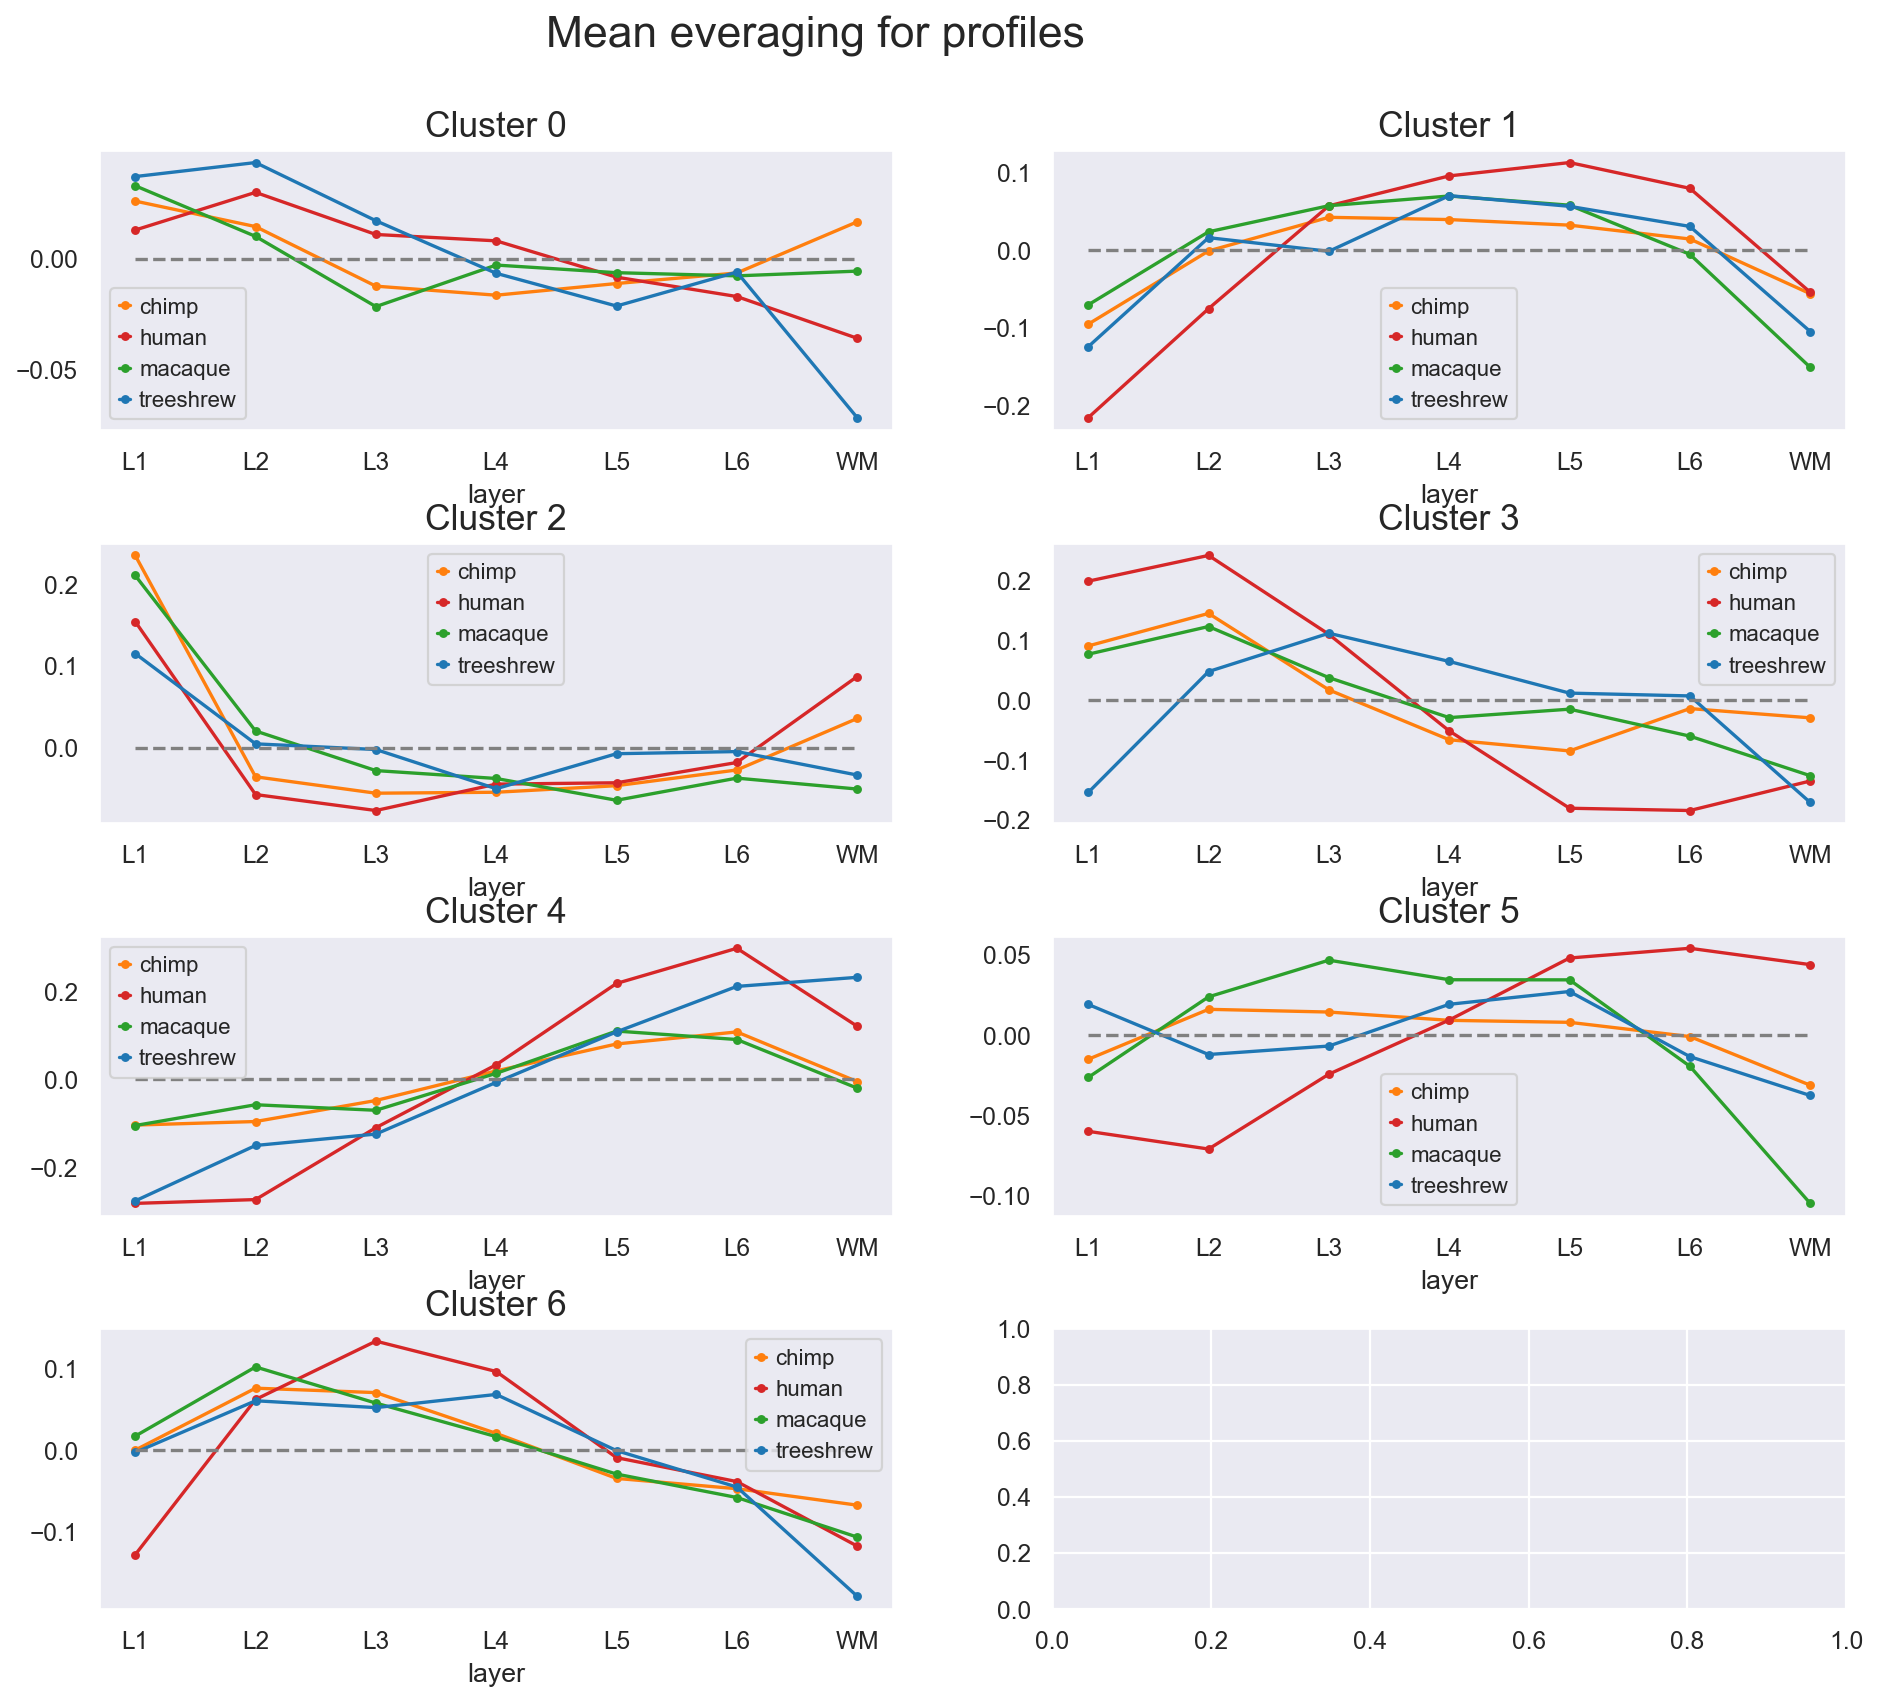

In [510]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.intersection(hs_genes_inter).tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Mean averaging for profiles', fontsize=20)

## Cluster profiles (Median)

Text(0.5, 0.98, 'Median everaging for profiles')

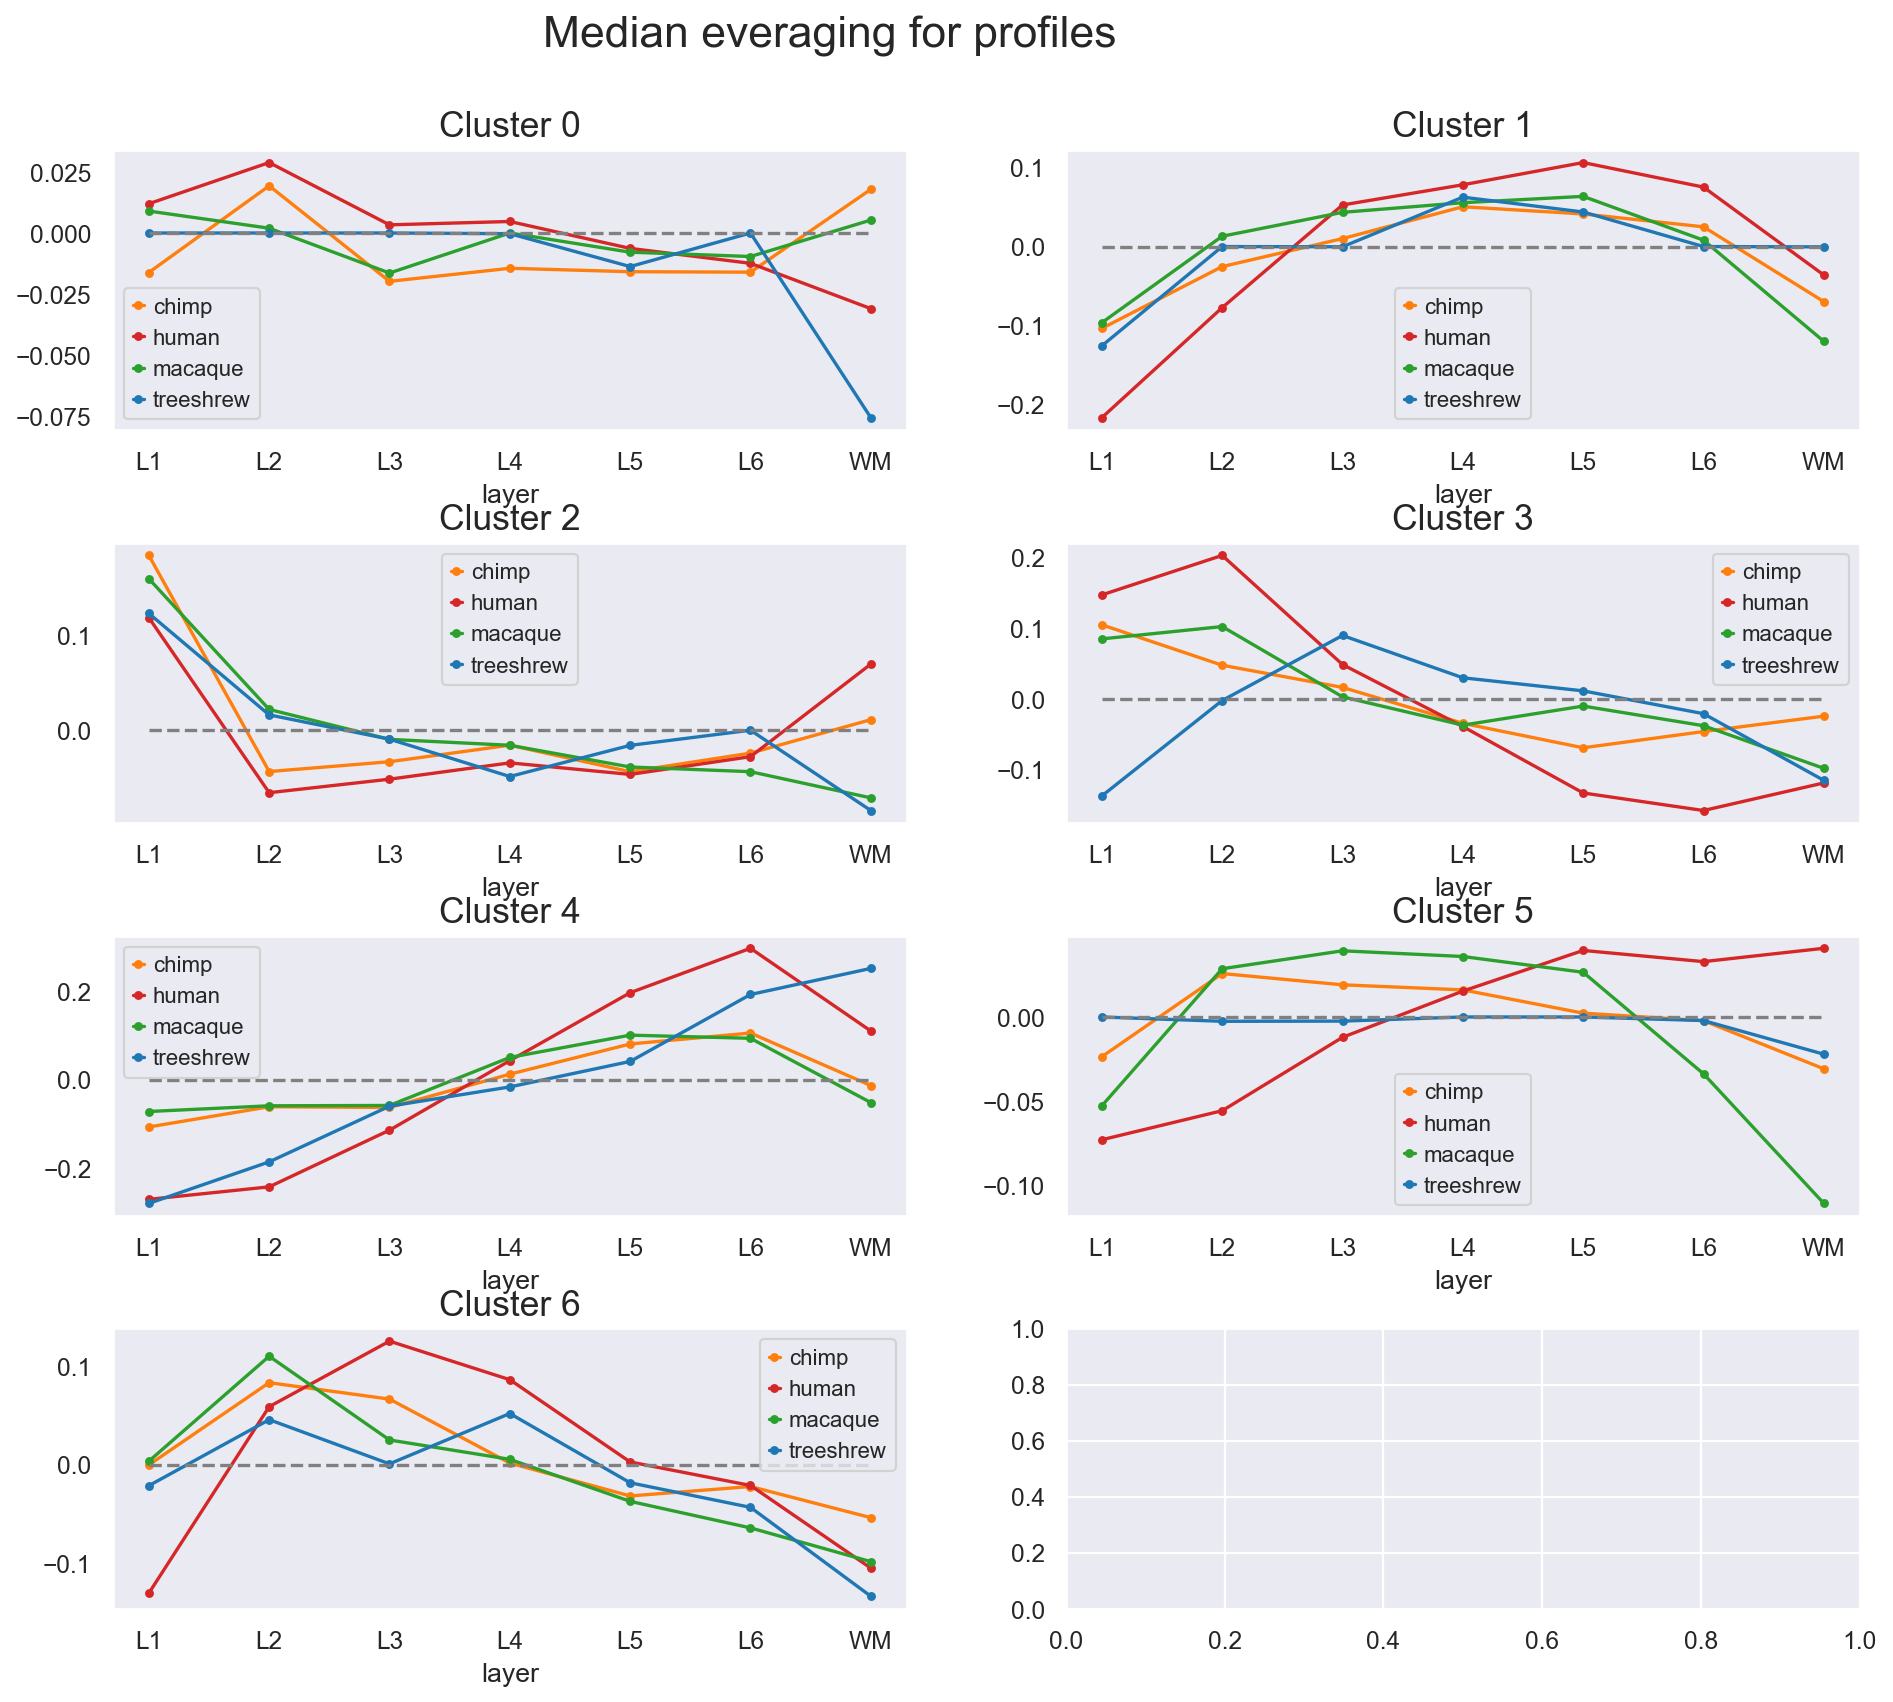

In [511]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.intersection(hs_genes_inter).tolist()

    (
        layer_mean[genes]
        .median(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Median averaging for profiles', fontsize=20)

In [512]:
# sns.set(font_scale=1)
# label = 3
# genes = hs_genes_inter.tolist()
# fig, axes = plt.subplots((len(genes) + 1) // 2, 2,  figsize=(14, 3.5 * len(genes) // 2), gridspec_kw={'hspace': 0.4})

# for gene, ax in zip(genes, axes.flatten()):
#     (
#         layer_mean[gene]
#         .reorder_levels(['layer', 'condition'])
#         .unstack().loc[layers]
#         .plot
#         .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
#     )
#     ax.legend(fontsize=10)
#     ax.set_title(f'{gene}', fontsize=16)
#     ax.grid(False)
#     ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')
# plt.savefig('hs_genes_profiles.pdf')

In [513]:
cs_genes = sign_genes['chimp-macaque'].intersection(sign_genes['human-chimp']).difference(sign_genes['human-macaque'])
cs_genes, cs_genes.size

(Index(['ACHE', 'ACTN2', 'ANK3', 'ANKIB1', 'ARF5', 'ARID4A', 'ARID4B', 'AZIN2',
        'BAIAP2', 'BTF3', 'CAMK2G', 'COBL', 'CTDNEP1', 'DCAKD', 'DCBLD2',
        'DENND4B', 'DNAJB6', 'DYNC1I2', 'DYNC1LI1', 'ENOX1', 'FAM71E1',
        'FAM76A', 'FAU', 'GIPC1', 'GOLPH3', 'HCCS', 'HEY1', 'HINT1', 'HINT2',
        'HMGCLL1', 'HNRNPA3', 'HSPB11', 'KCNC2', 'KLF3', 'KXD1', 'LCMT1',
        'LRP3', 'LSM5', 'MAP3K7', 'METTL5', 'MGST3', 'MICU1', 'MIF', 'MORN4',
        'MRPL23', 'MRPL37', 'MRPS36', 'MYCBP2', 'NCOA3', 'NELL2', 'NETO1',
        'NUAK1', 'NUBP2', 'NUDCD1', 'NUP93', 'PARP8', 'PBRM1', 'PDE4B',
        'PITHD1', 'PLCB1', 'PML', 'POLR2C', 'PRXL2B', 'PTOV1', 'RADX',
        'RASL11B', 'RETREG1', 'RIPOR2', 'RNF2', 'RPL10', 'RPL35A', 'RPL5',
        'RPS16', 'RPS29', 'RPS5', 'RSL24D1', 'SCRN3', 'SDHD', 'SEC13', 'SEMA3A',
        'SERPINE2', 'SGTB', 'SLIRP', 'SORL1', 'SPP1', 'SRI', 'STARD4', 'STT3B',
        'SULF1', 'TAGLN2', 'TBC1D24', 'TMEM259', 'TSPAN3', 'UQCRH', 'USP11',
        'UTP1

In [514]:
cs_genes_inter = df_4spe.columns.intersection(cs_genes)
cs_genes_inter.size

60

In [515]:
df_4spe_cs = df_4spe[cs_genes_inter]

In [516]:
df_annotation = df_4spe_cs.copy()
df_annotation['layer'] = adata_pb_4spe.obs.layer
df_annotation['condition'] = adata_pb_4spe.obs.condition

In [517]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

gene_name          ZBTB17    PITHD1    FAM76A     AZIN2     UTP11    MRPL37  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1    -0.050830 -0.120021  0.093791 -0.024870  0.016716 -0.060008   
          L2    -0.031148 -0.037826  0.083384 -0.028452 -0.011984 -0.031085   
          L3    -0.019490 -0.019130 -0.004356  0.008705 -0.029310 -0.010805   
          L4    -0.021841  0.018376 -0.105385  0.011918  0.001102 -0.011301   

gene_name           PDE4B       WLS   DENND4B     MGST3  ...     NUP93  \
condition layer                                          ...             
chimp     6a          NaN       NaN       NaN       NaN  ...       NaN   
          L1    -0.020838  0.160677  0.096483 -0.050735  ...  0.118650   
          L2    -0.028034 -0.048604 -0.009262 -0.145839  ...  0.011037   
          L3     0.034972 -0.151951 -0.000121 -0.013848  ...  0.038760   
          L4     0.051433 -0.048296 -0.028336  0.071119  ... -0.023170   

gene_name           DCAKD    BAIAP2     NETO1     PLCB1     WFDC2     NCOA3  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1     0.135104 -0.186372 -0.120203 -0.194523  0.102305  0.074538   
          L2     0.033378 -0.075413 -0.174555 -0.246275  0.002262  0.038630   
          L3    -0.059487  0.008780 -0.091121  0.037518 -0.028534 -0.009224   
          L4    -0.059855 -0.008087  0.010843  0.097284 -0.014523 -0.003903   

gene_name         TMEM259      LRP3     PTOV1  
condition layer                                
chimp     6a          NaN       NaN       NaN  
          L1    -0.031654  0.179930 -0.056096  
          L2    -0.020200  0.180120  0.023434  
          L3     0.003608  0.145959  0.020639  
          L4    -0.025835  0.002809 -0.029804  

[5 rows x 60 columns]

In [518]:
# sns.set(font_scale=1)
# label = 3
# genes = cs_genes_inter.tolist()
# fig, axes = plt.subplots((len(genes) + 1) // 2, 2,  figsize=(14, 3.5 * len(genes) // 2), gridspec_kw={'hspace': 0.4})

# for gene, ax in zip(genes, axes.flatten()):
#     (
#         layer_mean[gene]
#         .reorder_levels(['layer', 'condition'])
#         .unstack().loc[layers]
#         .plot
#         .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
#     )
#     ax.legend(fontsize=10)
#     ax.set_title(f'{gene}', fontsize=16)
#     ax.grid(False)
#     ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')
# plt.savefig('cs_genes_profiles.pdf')

# Intersection with ANOVA clusters

In [519]:
anova_hs_inter = hs_genes.intersection(anova_labels.index)
anova_hs_inter

Index(['ABHD6', 'ABI2', 'ADAM15', 'ADI1', 'ADORA1', 'AFTPH', 'AHNAK2', 'ALCAM',
       'ANK2', 'APOO',
       ...
       'VGLL4', 'VIPAS39', 'VLDLR', 'WWP1', 'YWHAE', 'YWHAH', 'ZBTB18',
       'ZBTB46', 'ZEB2', 'ZNF706'],
      dtype='object', length=210)

In [520]:
table_to_pivot = pd.concat([anova_labels.loc[anova_hs_inter], labels.loc[anova_hs_inter]], axis=1)
table_to_pivot.columns = ['ANOVA_labels', 'hs_labels']
pivot_labels_inter = table_to_pivot.groupby('ANOVA_labels').value_counts().unstack().fillna(0)
pivot_labels_inter

hs_labels        0     1     2     3     4     5    6
ANOVA_labels                                         
0              7.0   0.0   0.0  14.0   0.0   0.0  7.0
1             10.0   1.0   1.0   0.0   2.0   6.0  0.0
2              5.0  17.0   0.0   0.0  13.0  15.0  4.0
3              8.0   0.0   1.0   0.0   0.0   2.0  1.0
4              3.0   0.0   4.0   1.0   0.0   3.0  0.0
5             11.0   7.0   6.0   0.0   0.0  17.0  5.0
6             15.0   0.0  15.0   3.0   0.0   6.0  0.0

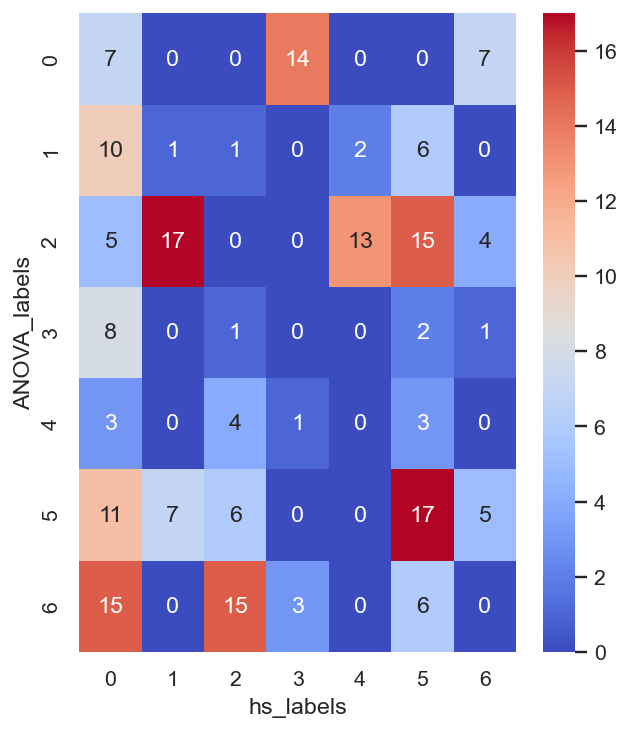

In [521]:
plt.figure(figsize=(5, 6), dpi=70)
sns.set(font_scale=1)
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f")
plt.grid(False)

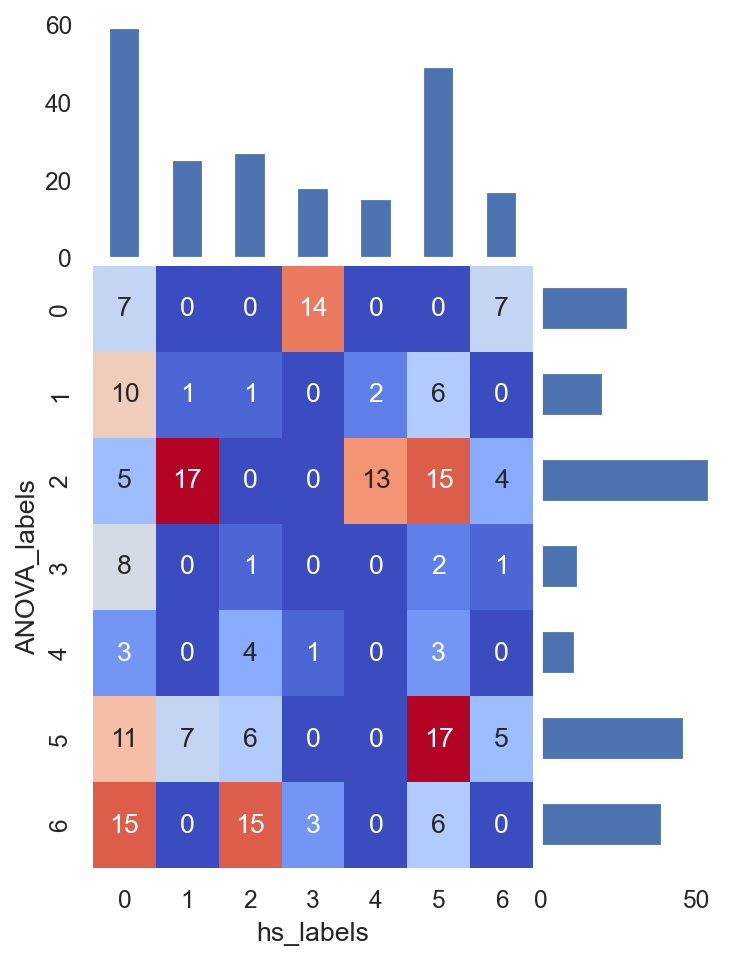

In [522]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 7))
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f", ax=ax, cbar=False)


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='40%', pad=0.05)
pivot_labels_inter.sum(axis=0).plot.bar(ax=cax)
cax.set_facecolor(color='white')
cax.get_xaxis().set_visible(False)

cax = divider.append_axes('right', size='40%', pad=0.05)
index_order = pivot_labels_inter.index[::-1]
pivot_labels_inter.sum(axis=1).loc[index_order].plot.barh(ax=cax)
cax.set_facecolor(color='white')
cax.get_yaxis().set_visible(False)

# Functional analysis

In [523]:
gene_clust = list()
enrich_results = list()

for label in tqdm(sorted(labels.unique())):
    genes = labels[labels == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of human-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/7 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [524]:
db_name = 'GO_Biological_Process_2021'
GeneCluster.enrich_geneclusters(gene_clust,db_name )

In [525]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                            
regulation of lymphocyte activation (GO:0051249)       1  0.012987        inf   
heme biosynthetic process (GO:0006783)                 2  0.013680  13.009804   
porphyrin-containing compound biosynthetic proc...     3  0.013680  13.009804   
negative regulation of G0 to G1 transition (GO:...     4  0.015653  12.006787   
protein polyubiquitination (GO:0000209)                5  0.017554   3.123992   

                                                    Combined score  \
Term                                                                 
regulation of lymphocyte activation (GO:0051249)               inf   
heme biosynthetic process (GO:0006783)                   55.835942   
porphyrin-containing compound biosynthetic proc...       55.835942   
negative regulation of G0 to G1 transition (GO:...       49.913278   
protein polyubiquitination (GO:0000209)                  12.628605   

                                                                             Overlapping genes  \
Term                                                                                             
regulation of lymphocyte activation (GO:0051249)                                      [DCAF15]   
heme biosynthetic process (GO:0006783)                                        [SLC25A38, TSPO]   
porphyrin-containing compound biosynthetic proc...                            [SLC25A38, TSPO]   
negative regulation of G0 to G1 transition (GO:...                                [MAX, PCGF2]   
protein polyubiquitination (GO:0000209)             [DCAF15, RNF34, CDC23, AMFR, PSME2, FBXO9]   

                                                    Adjusted P-value  \
Term                                                                   
regulation of lymphocyte activation (GO:0051249)            0.418477   
heme biosynthetic process (GO:0006783)                      0.418477   
porphyrin-containing compound biosynthetic proc...          0.418477   
negative regulation of G0 to G1 transition (GO:...          0.418477   
protein polyubiquitination (GO:0000209)                     0.418477   

                                                    Old p-value  \
Term                                                              
regulation of lymphocyte activation (GO:0051249)              0   
heme biosynthetic process (GO:0006783)                        0   
porphyrin-containing compound biosynthetic proc...            0   
negative regulation of G0 to G1 transition (GO:...            0   
protein polyubiquitination (GO:0000209)                       0   

                                                    Old adjusted p-value  \
Term                                                                       
regulation of lymphocyte activation (GO:0051249)                       0   
heme biosynthetic process (GO:0006783)                                 0   
porphyrin-containing compound biosynthetic proc...                     0   
negative regulation of G0 to G1 transition (GO:...                     0   
protein polyubiquitination (GO:0000209)                                0   

                                                    num_overlap_genes  \
Term                                                                    
regulation of lymphocyte activation (GO:0051249)                    1   
heme biosynthetic process (GO:0006783)                              2   
porphyrin-containing compound biosynthetic proc...                  2   
negative regulation of G0 to G1 transition (GO:...                  2   
protein polyubiquitination (GO:0000209)                             6   

                                                    neg_log10(p_adj)  \
Term                                                                   
regulation of lymphocyte activation (GO:0051249)            0.378328   
heme biosynthetic process (GO:0006783)                      0.378328  

In [526]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

22

In [527]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

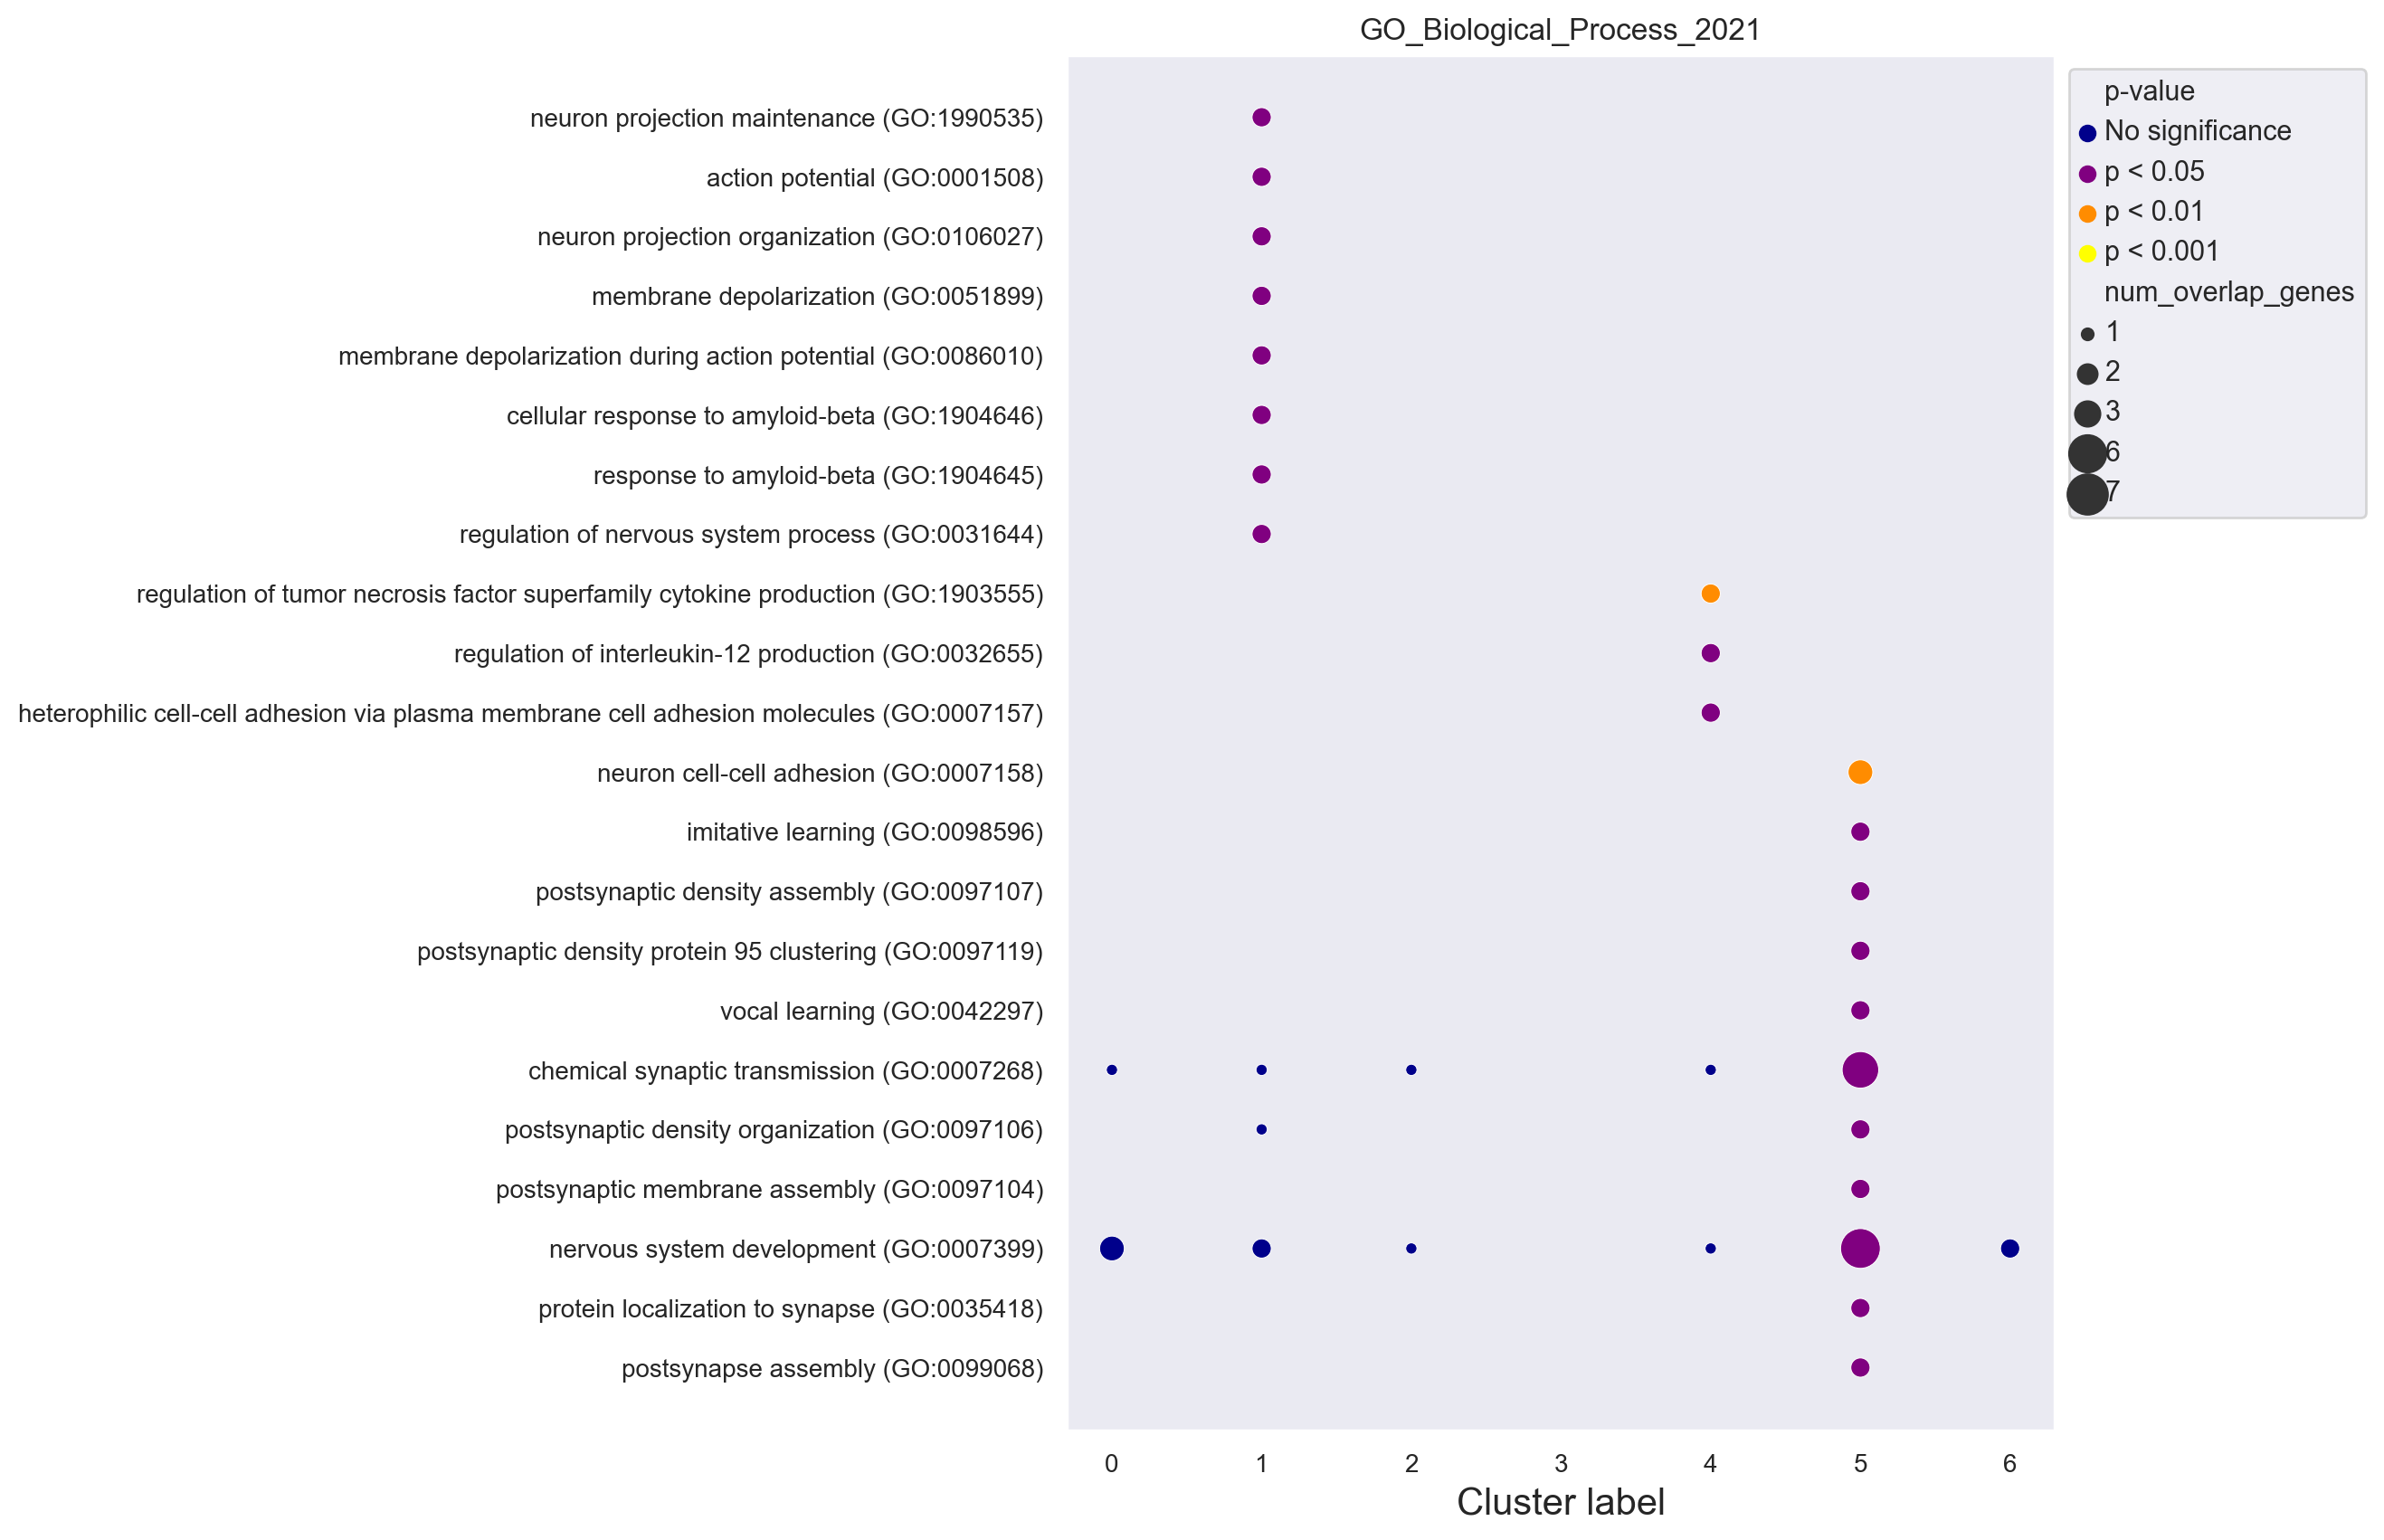

In [528]:
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [529]:
db_name = 'Azimuth_Cell_Types_2021'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [530]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                            
Intermediate B Cell, Kappa Light Chain CL0000785       1  0.012987        inf   
CD16+ Monocyte CL0002396                               2  0.025808  77.086957   
Nonclassical Monocyte CL0000875                        3  0.025808  77.086957   
Layer 6 Glutamatergic Neuron, Intratelencephalo...     4  0.025808  77.086957   
Intermediate Monocyte CL0002393                        5  0.038464  38.536232   

                                                    Combined score  \
Term                                                                 
Intermediate B Cell, Kappa Light Chain CL0000785               inf   
CD16+ Monocyte CL0002396                                281.913733   
Nonclassical Monocyte CL0000875                         281.913733   
Layer 6 Glutamatergic Neuron, Intratelencephalo...      281.913733   
Intermediate Monocyte CL0002393                         125.552219   

                                                   Overlapping genes  \
Term                                                                   
Intermediate B Cell, Kappa Light Chain CL0000785            [MARCKS]   
CD16+ Monocyte CL0002396                                     [COTL1]   
Nonclassical Monocyte CL0000875                              [COTL1]   
Layer 6 Glutamatergic Neuron, Intratelencephalo...           [PDE1A]   
Intermediate Monocyte CL0002393                              [COTL1]   

                                                    Adjusted P-value  \
Term                                                                   
Intermediate B Cell, Kappa Light Chain CL0000785            0.044875   
CD16+ Monocyte CL0002396                                    0.044875   
Nonclassical Monocyte CL0000875                             0.044875   
Layer 6 Glutamatergic Neuron, Intratelencephalo...          0.044875   
Intermediate Monocyte CL0002393                             0.044875   

                                                    Old p-value  \
Term                                                              
Intermediate B Cell, Kappa Light Chain CL0000785              0   
CD16+ Monocyte CL0002396                                      0   
Nonclassical Monocyte CL0000875                               0   
Layer 6 Glutamatergic Neuron, Intratelencephalo...            0   
Intermediate Monocyte CL0002393                               0   

                                                    Old adjusted p-value  \
Term                                                                       
Intermediate B Cell, Kappa Light Chain CL0000785                       0   
CD16+ Monocyte CL0002396                                               0   
Nonclassical Monocyte CL0000875                                        0   
Layer 6 Glutamatergic Neuron, Intratelencephalo...                     0   
Intermediate Monocyte CL0002393                                        0   

                                                    num_overlap_genes  \
Term                                                                    
Intermediate B Cell, Kappa Light Chain CL0000785                    1   
CD16+ Monocyte CL0002396                                            1   
Nonclassical Monocyte CL0000875                                     1   
Layer 6 Glutamatergic Neuron, Intratelencephalo...                  1   
Intermediate Monocyte CL0002393                                     1   

                                                    neg_log10(p_adj)  \
Term                                                                   
Intermediate B Cell, Kappa Light Chain CL0000785            1.347998   
CD16+ Monocyte CL0002396                                    1.347998   
Nonclassical Monocyte CL0000875                             1.347998   
Layer 6 Glutamatergic Neuron, Intratelencephalo...          1.347998   
Intermediate Monocyte CL0002393     

In [531]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

40

In [532]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

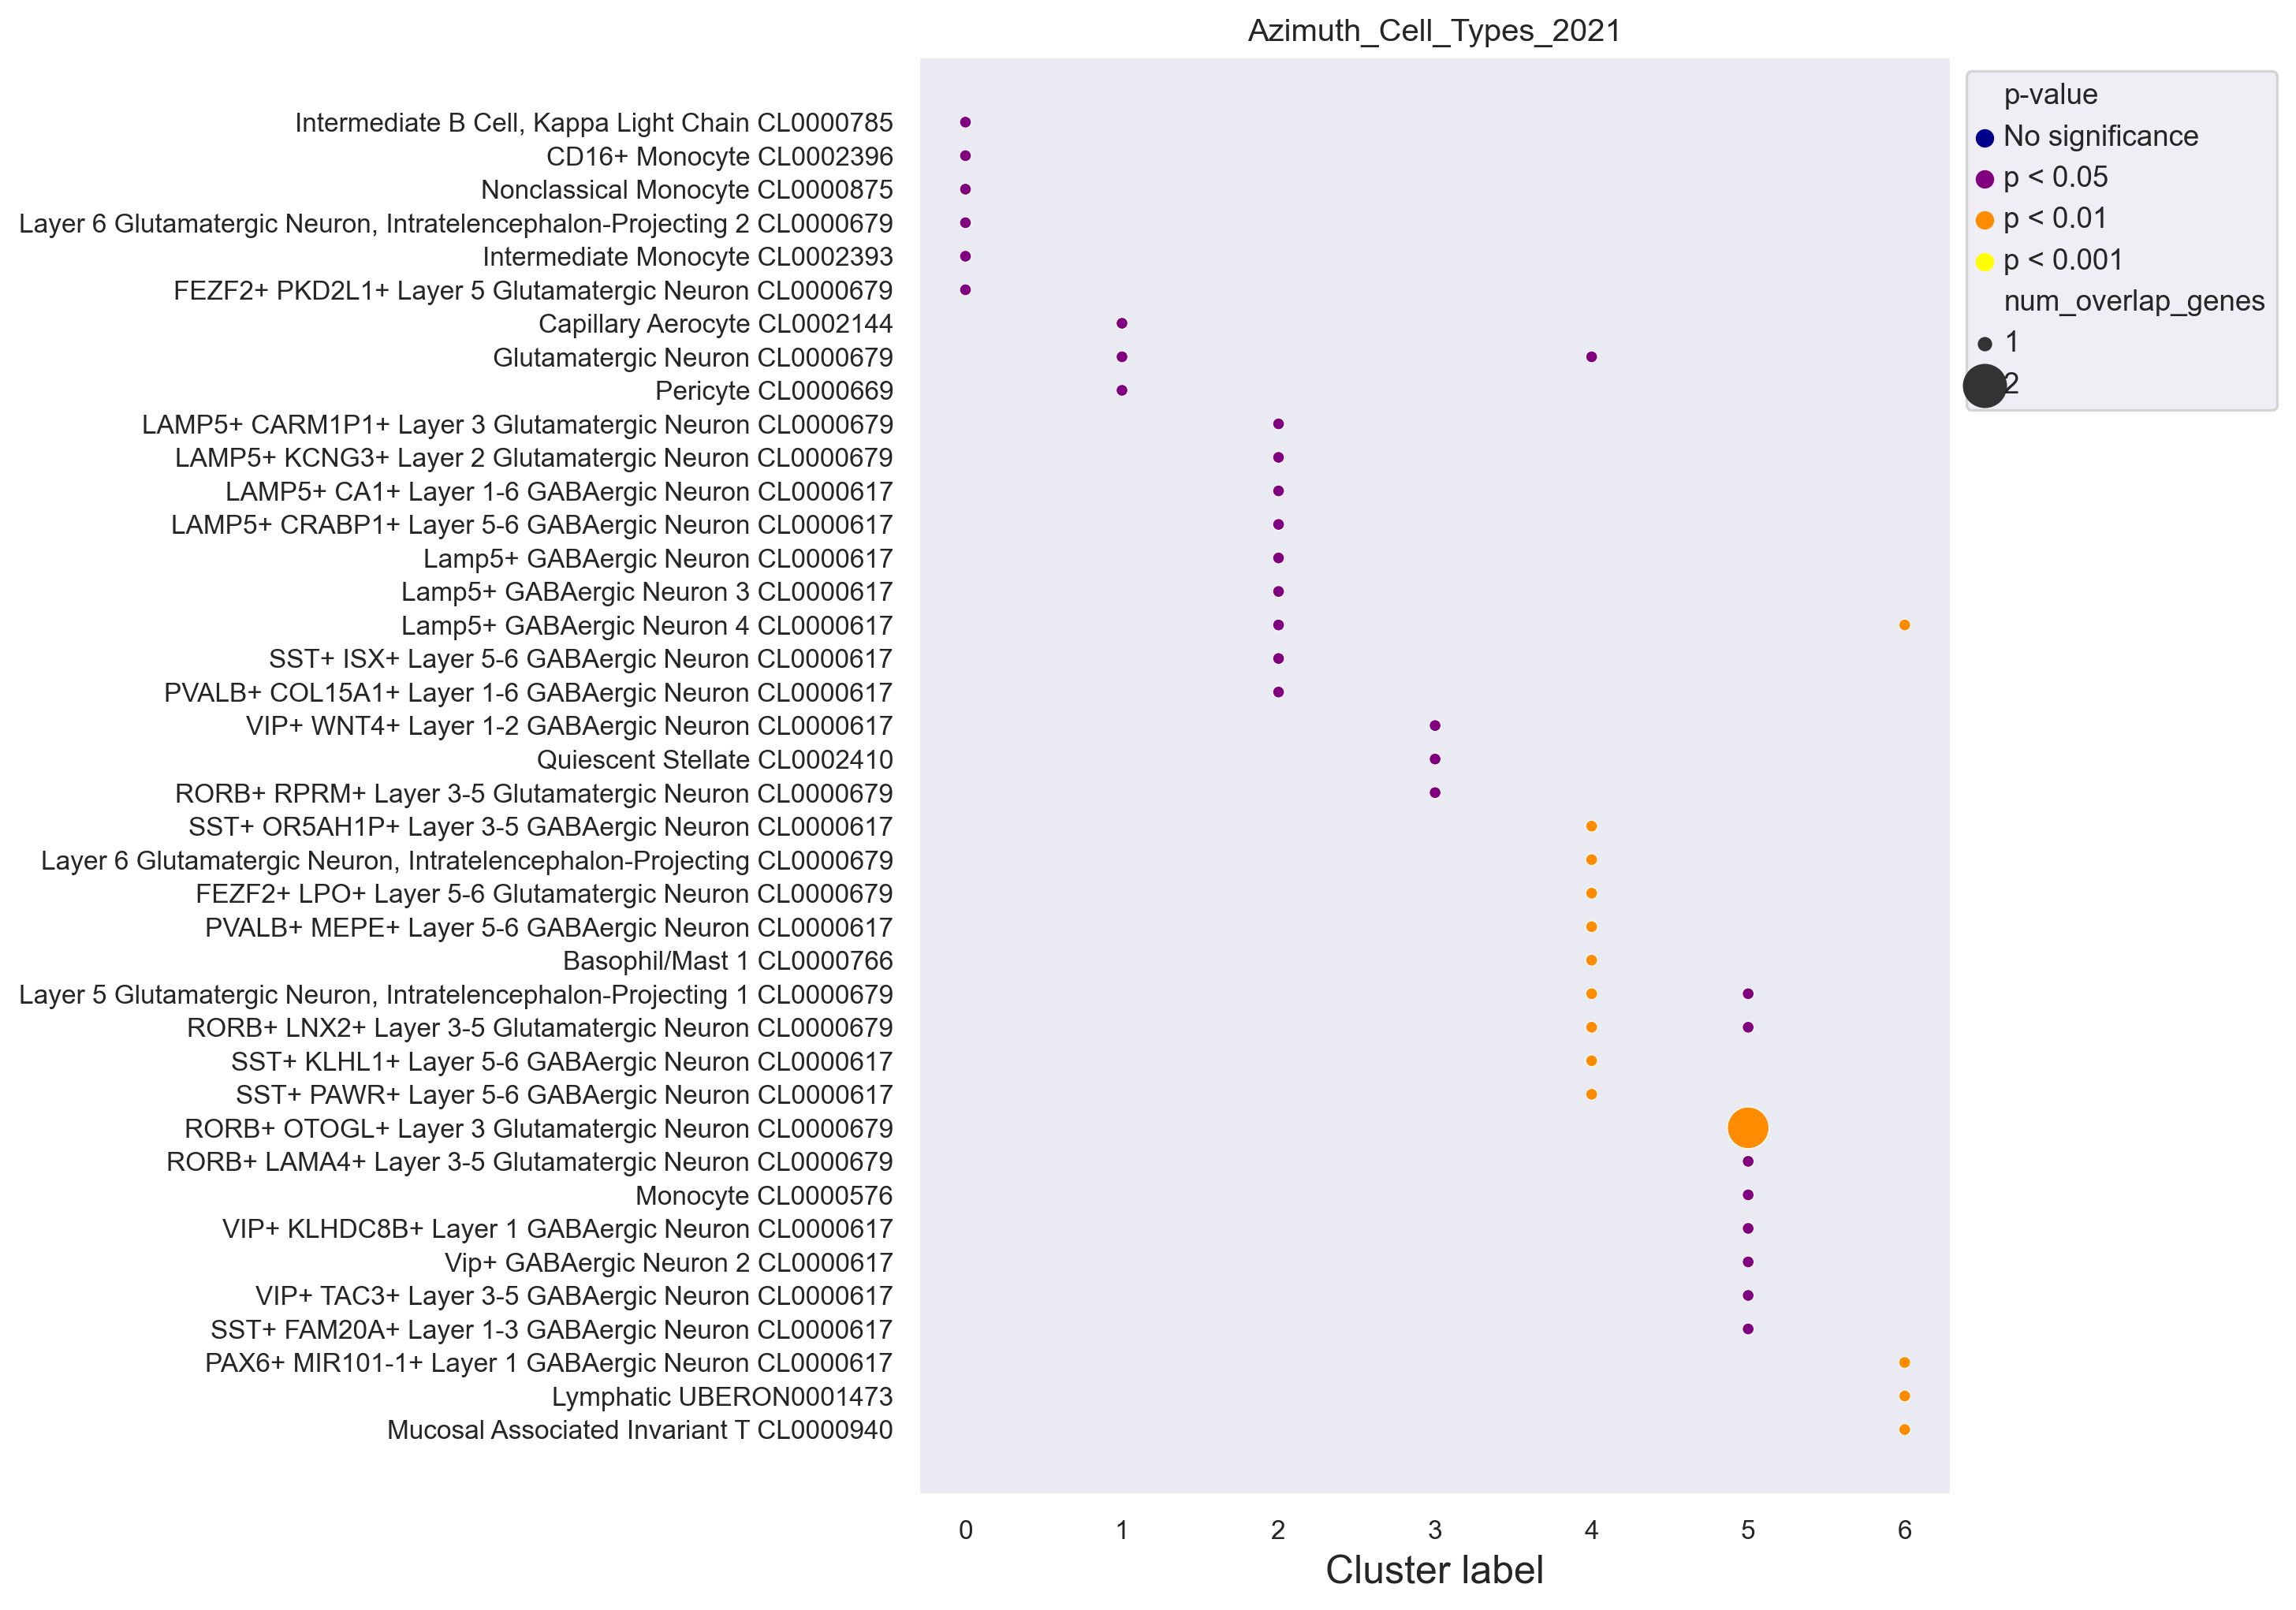

In [533]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [534]:
db_name = 'MGI_Mammalian_Phenotype_Level_4_2021'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [535]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                            
abnormal coat/hair pigmentation MP:0002075             1  0.000793   7.792899   
abnormal tumor susceptibility MP:0002166               2  0.000981  78.205882   
vertebral transformation MP:0003036                    3  0.001252  16.970149   
abnormal supraoccipital bone morphology MP:0000078     4  0.012987        inf   
abnormal talus morphology MP:0005109                   5  0.012987        inf   

                                                    Combined score  \
Term                                                                 
abnormal coat/hair pigmentation MP:0002075               55.637031   
abnormal tumor susceptibility MP:0002166                541.729703   
vertebral transformation MP:0003036                     113.410725   
abnormal supraoccipital bone morphology MP:0000078             inf   
abnormal talus morphology MP:0005109                           inf   

                                                                         Overlapping genes  \
Term                                                                                         
abnormal coat/hair pigmentation MP:0002075          [CDC23, MBD1, COTL1, SLC39A10, PLXNB2]   
abnormal tumor susceptibility MP:0002166                                   [ADAM15, PSME2]   
vertebral transformation MP:0003036                                    [MAU2, MBD1, PCGF2]   
abnormal supraoccipital bone morphology MP:0000078                                 [PCGF2]   
abnormal talus morphology MP:0005109                                              [PLAGL1]   

                                                    Adjusted P-value  \
Term                                                                   
abnormal coat/hair pigmentation MP:0002075                  0.136059   
abnormal tumor susceptibility MP:0002166                    0.136059   
vertebral transformation MP:0003036                         0.136059   
abnormal supraoccipital bone morphology MP:0000078          0.327515   
abnormal talus morphology MP:0005109                        0.327515   

                                                    Old p-value  \
Term                                                              
abnormal coat/hair pigmentation MP:0002075                    0   
abnormal tumor susceptibility MP:0002166                      0   
vertebral transformation MP:0003036                           0   
abnormal supraoccipital bone morphology MP:0000078            0   
abnormal talus morphology MP:0005109                          0   

                                                    Old adjusted p-value  \
Term                                                                       
abnormal coat/hair pigmentation MP:0002075                             0   
abnormal tumor susceptibility MP:0002166                               0   
vertebral transformation MP:0003036                                    0   
abnormal supraoccipital bone morphology MP:0000078                     0   
abnormal talus morphology MP:0005109                                   0   

                                                    num_overlap_genes  \
Term                                                                    
abnormal coat/hair pigmentation MP:0002075                          5   
abnormal tumor susceptibility MP:0002166                            2   
vertebral transformation MP:0003036                                 3   
abnormal supraoccipital bone morphology MP:0000078                  1   
abnormal talus morphology MP:0005109                                1   

                                                    neg_log10(p_adj)  \
Term                                                                   
abnormal coat/hair pigmentation MP:0002075                  0.866274   
abnormal tumor susceptibility MP:0002166                    0.866274   
vertebral transformation M

In [536]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

12

In [537]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

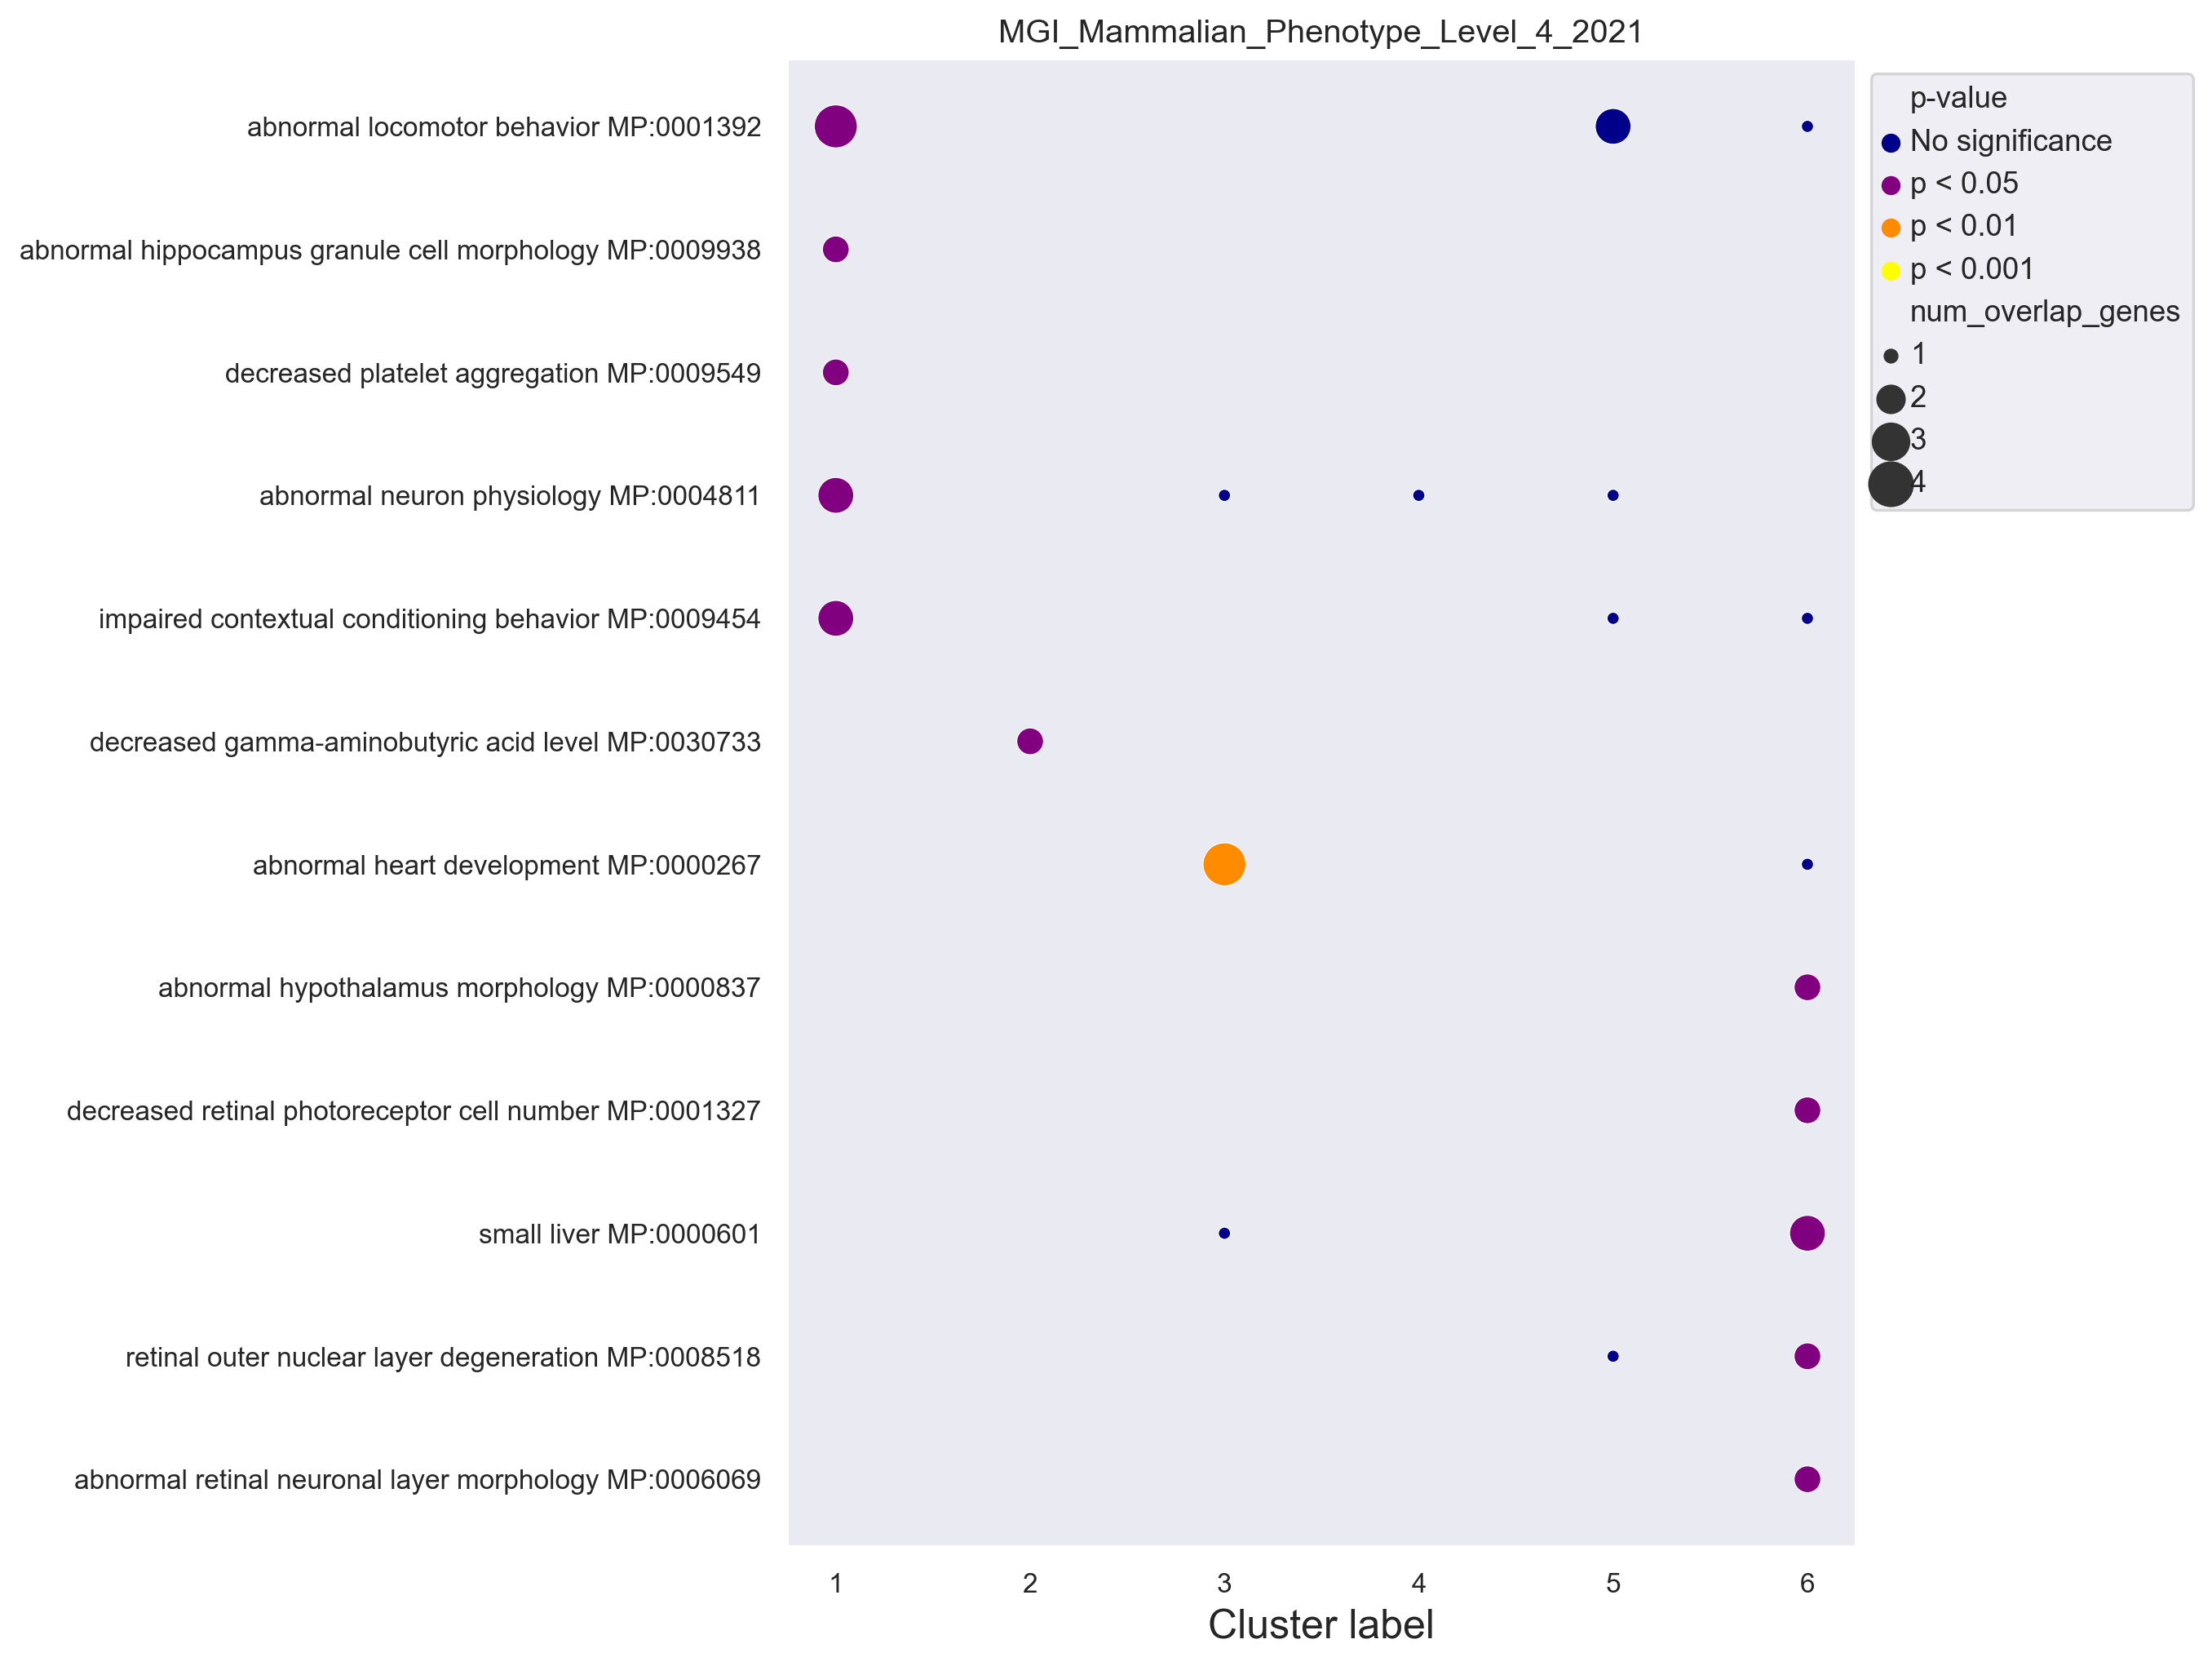

In [538]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [539]:
db_name = 'Reactome_2022'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [540]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                            
Synthesis Of 12-Eicosatetraenoic Acid Derivativ...     1  0.012987        inf   
Synthesis Of 15-Eicosatetraenoic Acid Derivativ...     2  0.012987        inf   
Transcriptional Regulation By E2F6 R-HSA-8953750       3  0.015653  12.006787   
Synthesis Of 5-Eicosatetraenoic Acids R-HSA-214...     4  0.025808  77.086957   
Biosynthesis Of E-series 18(S)-resolvins R-HSA-...     5  0.025808  77.086957   

                                                    Combined score  \
Term                                                                 
Synthesis Of 12-Eicosatetraenoic Acid Derivativ...             inf   
Synthesis Of 15-Eicosatetraenoic Acid Derivativ...             inf   
Transcriptional Regulation By E2F6 R-HSA-8953750         49.913278   
Synthesis Of 5-Eicosatetraenoic Acids R-HSA-214...      281.913733   
Biosynthesis Of E-series 18(S)-resolvins R-HSA-...      281.913733   

                                                   Overlapping genes  \
Term                                                                   
Synthesis Of 12-Eicosatetraenoic Acid Derivativ...            [GPX4]   
Synthesis Of 15-Eicosatetraenoic Acid Derivativ...            [GPX4]   
Transcriptional Regulation By E2F6 R-HSA-8953750        [MAX, PCGF2]   
Synthesis Of 5-Eicosatetraenoic Acids R-HSA-214...            [GPX4]   
Biosynthesis Of E-series 18(S)-resolvins R-HSA-...            [GPX4]   

                                                    Adjusted P-value  \
Term                                                                   
Synthesis Of 12-Eicosatetraenoic Acid Derivativ...           0.68873   
Synthesis Of 15-Eicosatetraenoic Acid Derivativ...           0.68873   
Transcriptional Regulation By E2F6 R-HSA-8953750             0.68873   
Synthesis Of 5-Eicosatetraenoic Acids R-HSA-214...           0.68873   
Biosynthesis Of E-series 18(S)-resolvins R-HSA-...           0.68873   

                                                    Old p-value  \
Term                                                              
Synthesis Of 12-Eicosatetraenoic Acid Derivativ...            0   
Synthesis Of 15-Eicosatetraenoic Acid Derivativ...            0   
Transcriptional Regulation By E2F6 R-HSA-8953750              0   
Synthesis Of 5-Eicosatetraenoic Acids R-HSA-214...            0   
Biosynthesis Of E-series 18(S)-resolvins R-HSA-...            0   

                                                    Old adjusted p-value  \
Term                                                                       
Synthesis Of 12-Eicosatetraenoic Acid Derivativ...                     0   
Synthesis Of 15-Eicosatetraenoic Acid Derivativ...                     0   
Transcriptional Regulation By E2F6 R-HSA-8953750                       0   
Synthesis Of 5-Eicosatetraenoic Acids R-HSA-214...                     0   
Biosynthesis Of E-series 18(S)-resolvins R-HSA-...                     0   

                                                    num_overlap_genes  \
Term                                                                    
Synthesis Of 12-Eicosatetraenoic Acid Derivativ...                  1   
Synthesis Of 15-Eicosatetraenoic Acid Derivativ...                  1   
Transcriptional Regulation By E2F6 R-HSA-8953750                    2   
Synthesis Of 5-Eicosatetraenoic Acids R-HSA-214...                  1   
Biosynthesis Of E-series 18(S)-resolvins R-HSA-...                  1   

                                                    neg_log10(p_adj)  \
Term                                                                   
Synthesis Of 12-Eicosatetraenoic Acid Derivativ...          0.161951   
Synthesis Of 15-Eicosatetraenoic Acid Derivativ...          0.161951   
Transcriptional Regulation By E2F6 R-HSA-8953750            0.161951   
Synthesis Of 5-Eicosatetraenoic Acids R-HSA-214...          0.161951   
Biosynthesis Of E-series 18(S)-resol

In [541]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

22

In [542]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

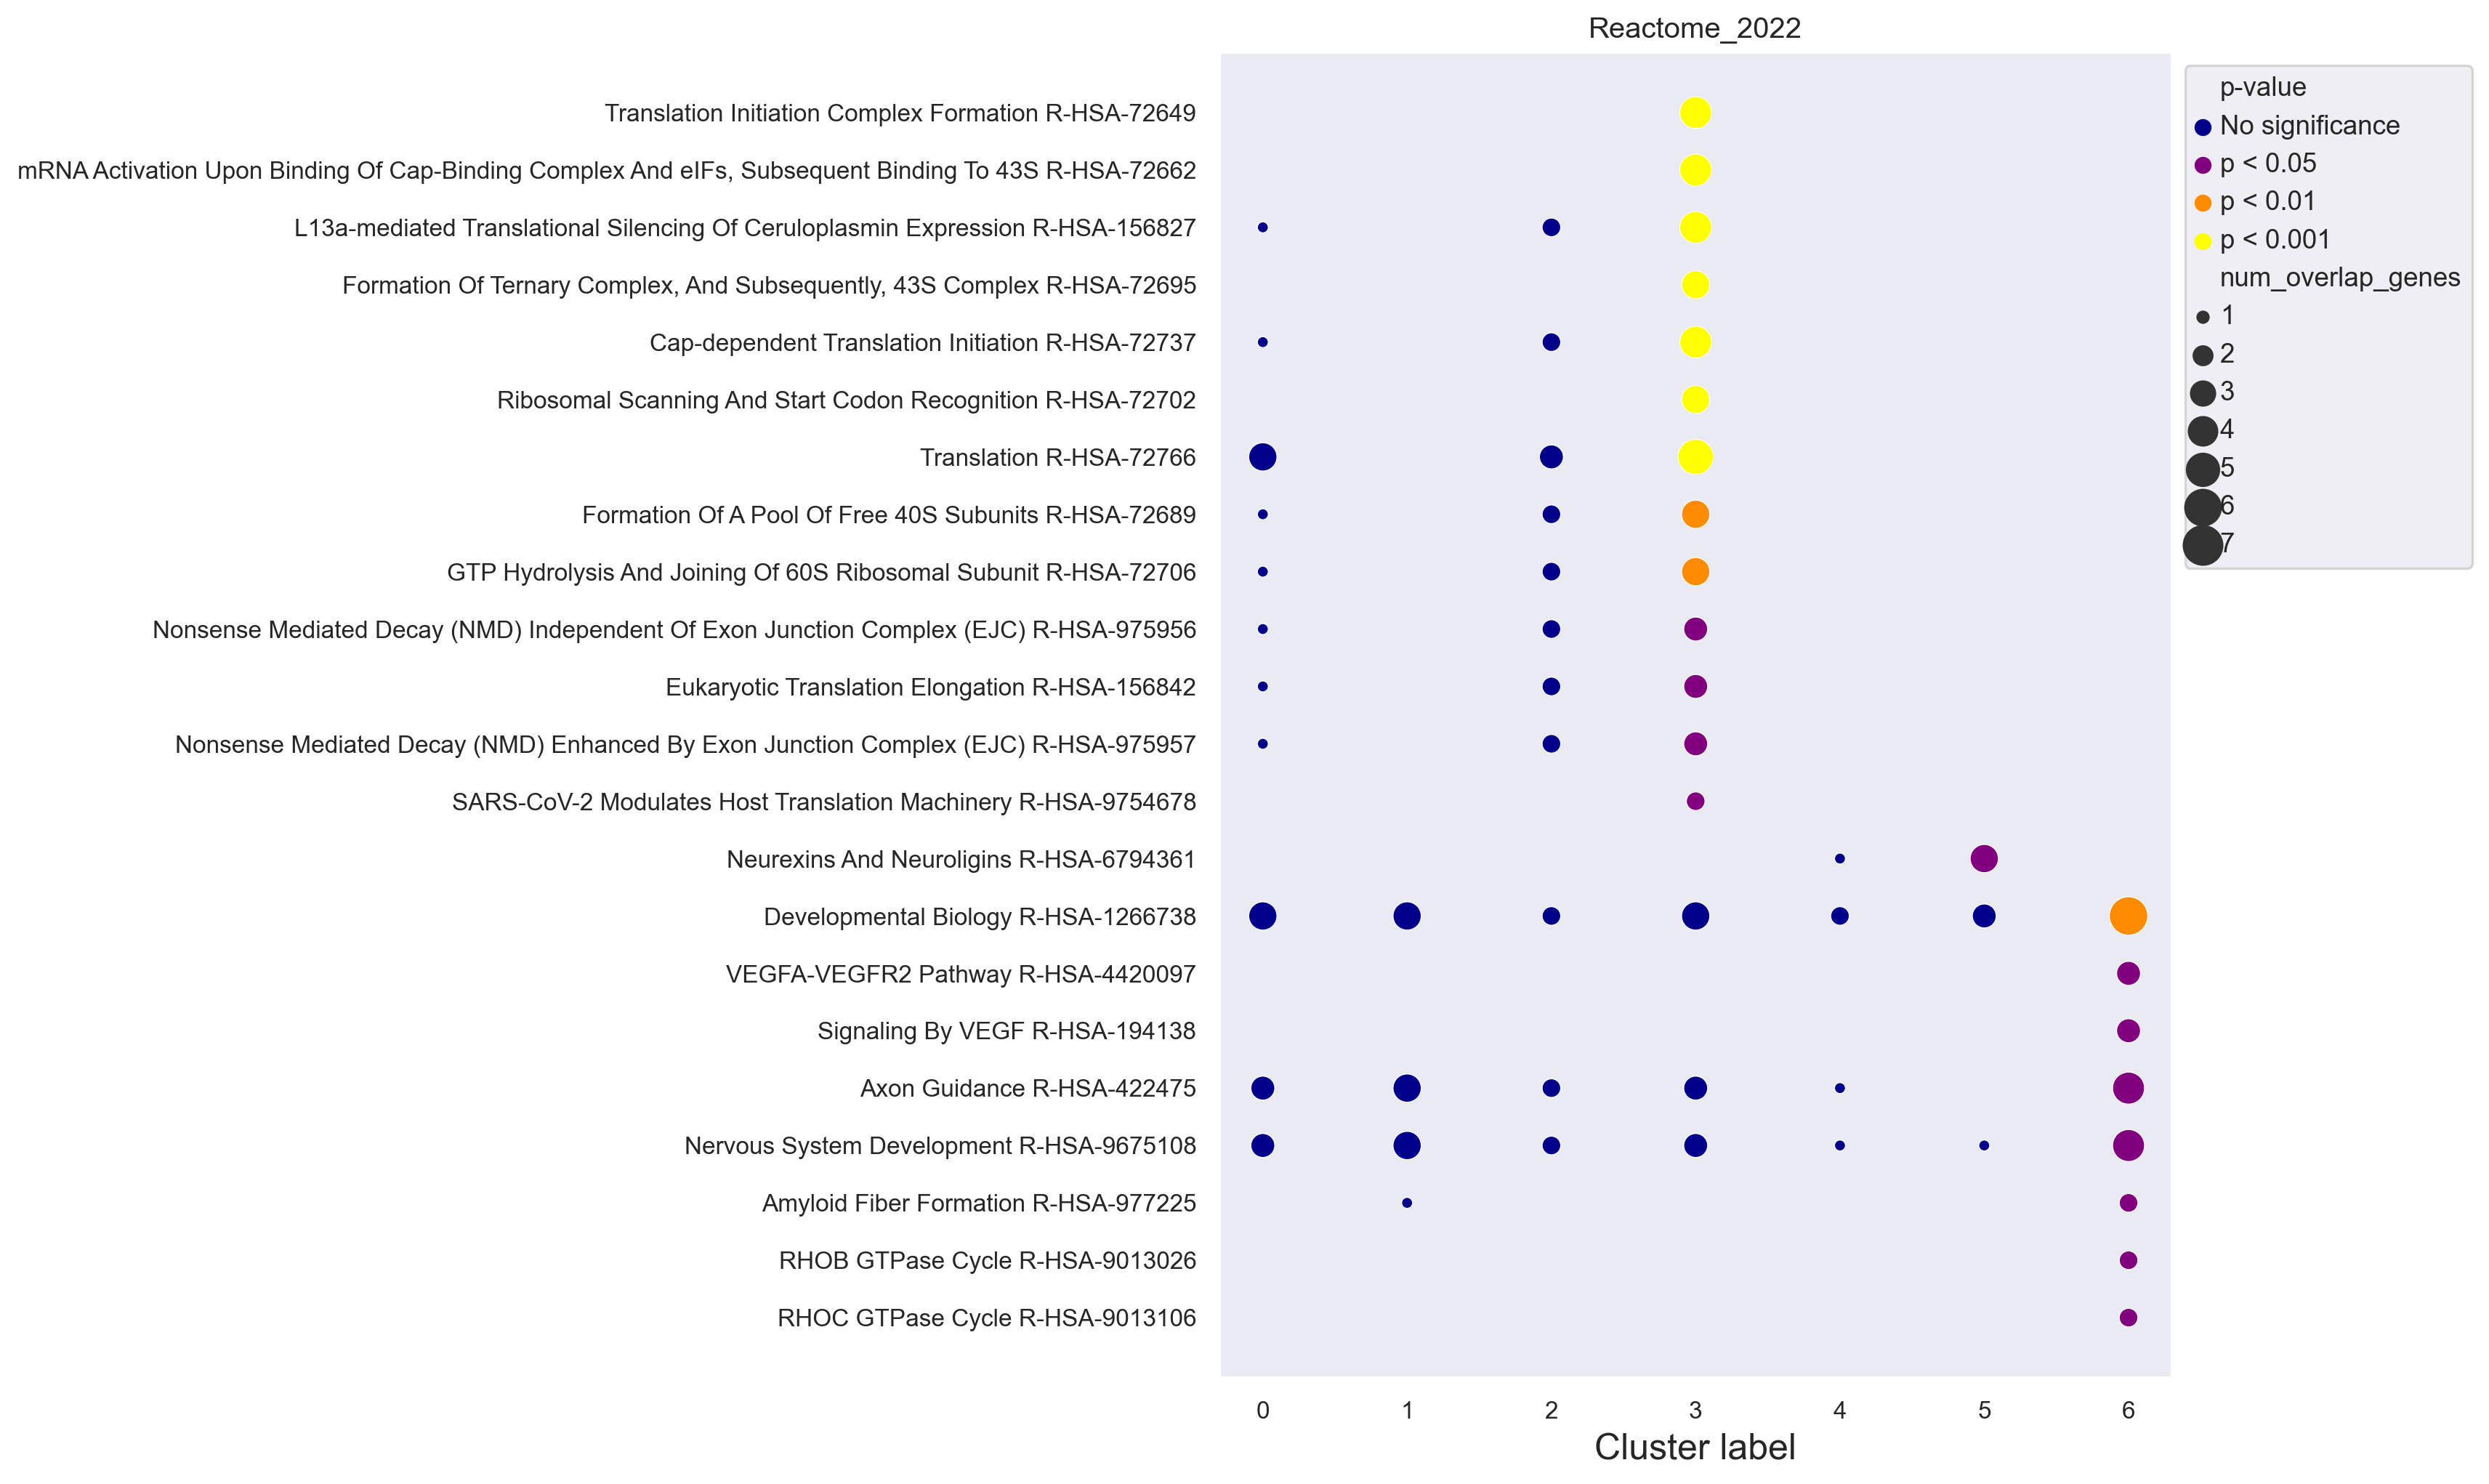

In [543]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [544]:
db_name = 'KEGG_2021_Human'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [545]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val   Z-score  Combined score  \
Term                                                                  
MicroRNAs in cancer           1  0.030950  4.719403       16.401701   
Glioma                        2  0.050589  5.988688       17.870321   
Small cell lung cancer        3  0.060715  5.366126       15.033534   
Calcium signaling pathway     4  0.098662  3.982655        9.224048   
Taste transduction            5  0.111070  9.623188       21.147902   

                               Overlapping genes  Adjusted P-value  \
Term                                                                 
MicroRNAs in cancer        [MARCKS, ZEB2, EFNA2]          0.682651   
Glioma                         [CAMK1G, GADD45G]          0.682651   
Small cell lung cancer            [MAX, GADD45G]          0.682651   
Calcium signaling pathway        [PDE1A, CAMK1G]          0.682651   
Taste transduction                       [PDE1A]          0.682651   

                           Old p-value  Old adjusted p-value  \
Term                                                           
MicroRNAs in cancer                  0                     0   
Glioma                               0                     0   
Small cell lung cancer               0                     0   
Calcium signaling pathway            0                     0   
Taste transduction                   0                     0   

                           num_overlap_genes  neg_log10(p_adj)  cluster_label  
Term                                                                           
MicroRNAs in cancer                        3          0.165801              0  
Glioma                                     2          0.165801              0  
Small cell lung cancer                     2          0.165801              0  
Calcium signaling pathway                  2          0.165801              0  
Taste transduction                         1          0.165801              0

In [546]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

1

In [547]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

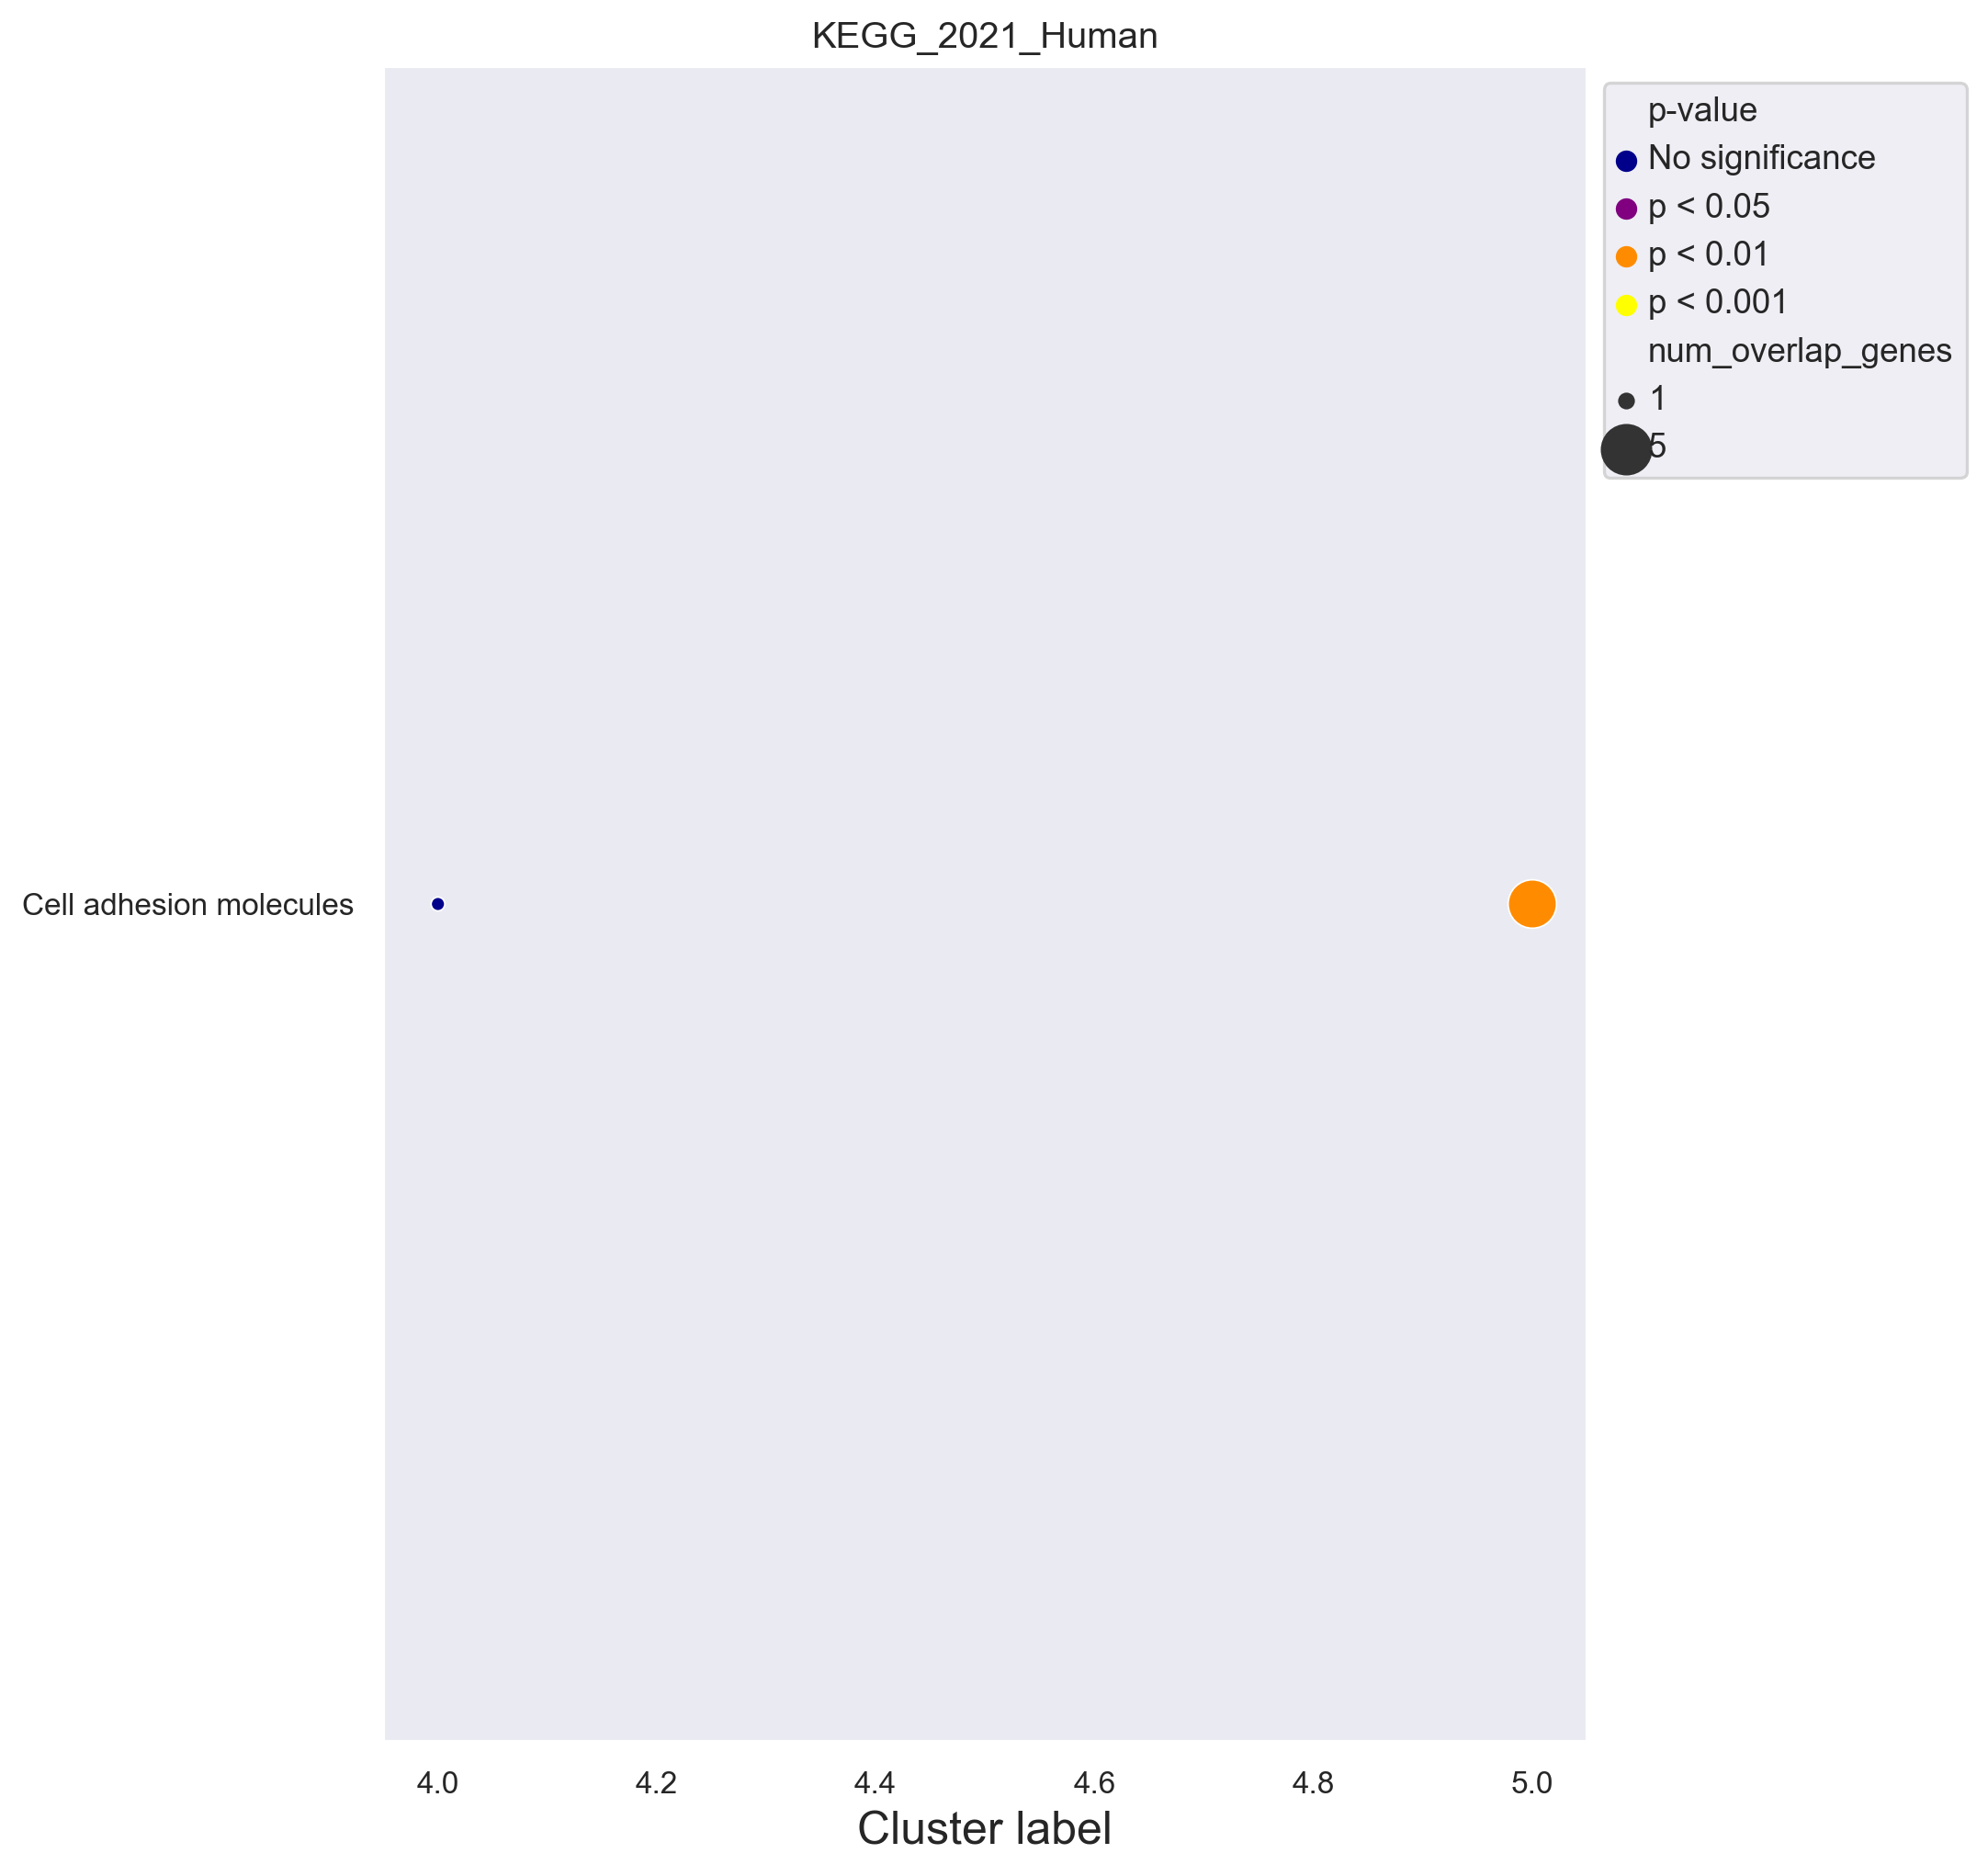

In [548]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))